In [5]:
import sys
%pip install ROOT

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement ROOT (from versions: none)
ERROR: No matching distribution found for ROOT
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import numpy as np
import dask
import hist
import uproot
import awkward as ak
import pandas as pd
import awkward_pandas as akpd
#import ROOT
#from ROOT import *

from scipy.optimize import curve_fit

import coffea.processor as processor
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory
import hist.dask as hda
import dask_awkward as dak
from awkward._connect import numexpr

from matplotlib import pyplot as plt
import awkward as ak
import dask
from hist.dask import Hist
from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea.analysis_tools import PackedSelection
import mplhep
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

num_evaluate = numexpr.evaluate

#from dask_jobqueue import SLURMCluster
from distributed import Client

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import matplotlib.pyplot as plt



/tmp/ipykernel_392/2349850832.py:17: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import base, vector


In [2]:
for entry in (ak, akpd, np, pd):
    print(f"{entry.__name__:15} {entry.__version__}")

awkward         2.6.7
awkward_pandas  2023.8.0
numpy           1.24.3
pandas          2.0.3


## Uproot Method

In [3]:
# s3df file path
#file_path = "/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
# uchicago file path
file_path = "/data/dliu64/Higgs_analysis/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root"
sample_file = uproot.open(file_path)
sample_file.keys()
#sample_file.classnames()

# ttree and tree1 are equivalent
ttree = sample_file['evttree']
#ttree1 = uproot.open("/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root:evttree")

# There are several ways to visit the items in ttree
ttree.keys() # item_name
#ttree.values() # item_name + mapping_address by reading it
#ttree.typenames() # item_name + typename without reading it
#ttree.show() # item_name + typename + interpretation (indicate how data will be interpreted as an array)

['runNumber',
 'eventNumber',
 'lumiBlock',
 'averagePU',
 'eventPU',
 'mcFlag',
 'mcProcess',
 'jetCalConf',
 'fatJetCalConf',
 'HLT_j420_L1J100',
 'HLT_j460_L1J100',
 'HLT_j480_L1J100',
 'HLT_j460_a10r_L1J100',
 'HLT_j460_a10r_L1SC111_CJ15',
 'HLT_j360_a10t_lcw_jes_L1J100',
 'HLT_j420_a10t_lcw_jes_L1J100',
 'HLT_j460_a10t_lcw_jes_L1J100',
 'HLT_j480_a10t_lcw_jes_L1J100',
 'HLT_j460_a10_lcw_subjes_L1J100',
 'HLT_j420_35smcINF_a10t_lcw_jes_L1J100',
 'HLT_j420_35smcINF_a10t_lcw_jes_L1SC111_CJ15',
 'HLT_j360_a10sd_cssk_pf_jes_ftf_preselj225_L1J100',
 'HLT_j360_a10sd_cssk_pf_jes_ftf_preselj225_L1SC111_CJ15',
 'HLT_j420_35smcINF_a10sd_cssk_pf_jes_ftf_preselj225_L1J100',
 'HLT_j460_a10sd_cssk_pf_jes_ftf_preselj225_L1J100',
 'HLT_2j330_35smcINF_a10sd_cssk_pf_jes_ftf_presel2j225_L1J100',
 'HLT_2j330_35smcINF_a10t_lcw_jes_L1J100',
 'eventMCWeight',
 'truthPVtxX',
 'truthPVtxY',
 'truthPVtxZ',
 'pVtxZ',
 'MET',
 'phiMET',
 'bosonPdgId',
 'bosonStatus',
 'bosonBarcode',
 'bosonPt',
 'bosonPx',
 

In [ ]:
with uproot.open(file_path, handler=uproot.MemmapSource) as file:
    dataset = file["evttree"].arrays()

## Explore the inner structure of the ntuple

In [ ]:
len(dataset)

In [15]:
a = np.array([[1,2,3], [3, 4, 5], [6, 7, 8]])
np.sum(a, axis=1)

array([ 6, 12, 21])

In [12]:
dataset['fatJetPt'][:3]

<Array [[615, 295], [434, 413], [526, 423]] type='3 * var * float32'>

In [4]:
# barnch_filter is a busket to contain variables you're gonna use in the branches
branch_filter = {'fatJetGN2XHbb', 'fatJetGN2XHcc', 'fatJetGN2XQCD', 'fatJetPt', 'fatJetM', 'fatJetNCHadrons', 'fatJetNBHadrons', 'vrJetIdFatJet', 'vrJetHadronGhostTruthLabelID', 'vrJetPt', 'vrJetM', 'eventMCWeight'}
dx = 5
bins = np.arange(0,600,dx)

weight_histo_bb = []
weight_histo_cc = []
weight_histo_qq = []
weight_histo_bq = []
weight_histo_cq = []

unweighted_vrjet_histo_bb = np.zeros(len(bins)-1)
unweighted_vrjet_histo_cc = np.zeros(len(bins)-1)
unweighted_vrjet_histo_qq = np.zeros(len(bins)-1)
unweighted_vrjet_histo_bq = np.zeros(len(bins)-1)
unweighted_vrjet_histo_cq = np.zeros(len(bins)-1)

vrjet_histo_bb = np.zeros(len(bins)-1)
vrjet_histo_cc = np.zeros(len(bins)-1)
vrjet_histo_qq = np.zeros(len(bins)-1)
vrjet_histo_bq = np.zeros(len(bins)-1)
vrjet_histo_cq = np.zeros(len(bins)-1)

start = time.process_time()
for event, report in ttree.iterate(
    library="ak",
    step_size=50000,
    filter_name=branch_filter,
    report=True,
):
    
    vrjet_mask = num_evaluate("(vrJetIdFatJet==0) & (vrJetPt>20)", event) #vrjet_cut: vrJetIdFatJet=0 means leading vrjets
    vrjet_type = event['vrJetHadronGhostTruthLabelID'][vrjet_mask]
    
    
    # Count the number of quarks, B Hadrons and C Hadrons
    q = ak.num(vrjet_type[vrjet_type==0])
    b = ak.num(vrjet_type[vrjet_type==5])
    c = ak.num(vrjet_type[vrjet_type==4])

    # Using critia as a filter to select fatJetM
    fatjet_bb = event['fatJetM'][b==2]
    fatjet_cc = event['fatJetM'][c==2]
    fatjet_bq = event['fatJetM'][(b==1)&(q>0)]
    fatjet_cq = event['fatJetM'][(c==1)&(q>0)]
    fatjet_qq = event['fatJetM'][(q>1)&(b==0)&(c==0)]

    weight_bb = event['eventMCWeight'][b==2]
    #print(weight_bb)
    weight_cc = event['eventMCWeight'][c==2]
    weight_bq = event['eventMCWeight'][(b==1)&(q>0)]
    weight_cq = event['eventMCWeight'][(c==1)&(q>0)]
    weight_qq = event['eventMCWeight'][(q>1)&(b==0)&(c==0)]

    # Only need leading jet
    fatjet_bb = fatjet_bb[:, 0].to_numpy()
    fatjet_cc = fatjet_cc[:, 0].to_numpy()
    fatjet_bq = fatjet_bq[:, 0].to_numpy()
    fatjet_cq = fatjet_cq[:, 0].to_numpy()
    fatjet_qq = fatjet_qq[:, 0].to_numpy()

    # make histogram
    
    bb, edges = np.histogram(fatjet_bb, bins=bins, weights=weight_bb.to_numpy())
    cc, edges = np.histogram(fatjet_cc, bins=bins, weights=weight_cc.to_numpy())
    bq, edges = np.histogram(fatjet_bq, bins=bins, weights=weight_bq.to_numpy())
    cq, edges = np.histogram(fatjet_cq, bins=bins, weights=weight_cq.to_numpy())
    qq, edges = np.histogram(fatjet_qq, bins=bins, weights=weight_qq.to_numpy())

    un_bb, edges = np.histogram(fatjet_bb, bins=bins)
    un_cc, edges = np.histogram(fatjet_cc, bins=bins)
    un_bq, edges = np.histogram(fatjet_bq, bins=bins)
    un_cq, edges = np.histogram(fatjet_cq, bins=bins)
    un_qq, edges = np.histogram(fatjet_qq, bins=bins)
    
    vrjet_histo_bb += bb
    vrjet_histo_cc += cc
    vrjet_histo_bq += bq
    vrjet_histo_cq += cq
    vrjet_histo_qq += qq
    
    unweighted_vrjet_histo_bb += un_bb
    unweighted_vrjet_histo_cc += un_cc
    unweighted_vrjet_histo_bq += un_bq
    unweighted_vrjet_histo_cq += un_cq
    unweighted_vrjet_histo_qq += un_qq

    weight_histo_bb += weight_bb.tolist()
    weight_histo_cc += weight_cc.tolist()
    weight_histo_bq += weight_bq.tolist()
    weight_histo_cq += weight_cq.tolist()
    weight_histo_qq += weight_qq.tolist()
print(time.process_time() - start)    


14.477758722


### Unweighted VS weighted # of events and fraction

"\naxs1[0].stairs(unweighted_vrjet_histo_bb/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bb')\naxs1[0].stairs(unweighted_vrjet_histo_cc/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cc')\naxs1[0].stairs(unweighted_vrjet_histo_qq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_qq')\naxs1[0].stairs(unweighted_vrjet_histo_bq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bq')\naxs1[0].stairs(unweighted_vrjet_histo_cq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cq')\naxs1[0].set_ylabel('unweighted fraction')\naxs1[0].set_title(r'unweighted/weighted fraction for different flavors in QCD background')\naxs1[0].legend()\naxs1[0].set_yscale('log')\naxs1[0].set_ylim(1e-2,2)\n\naxs1[1].stairs(vrjet_histo_bb/vrjet_histo_tot, edges, label='vrjet_bb')\naxs1[1].stairs(vrjet_histo_cc/vrjet_histo_tot, edges, label='vrjet_cc')\naxs1[1].stairs(vrjet_histo_qq/vrjet_histo_tot, edges, label='vrjet_qq')\naxs1[1].stairs(vrjet_histo_bq/vrjet_hist

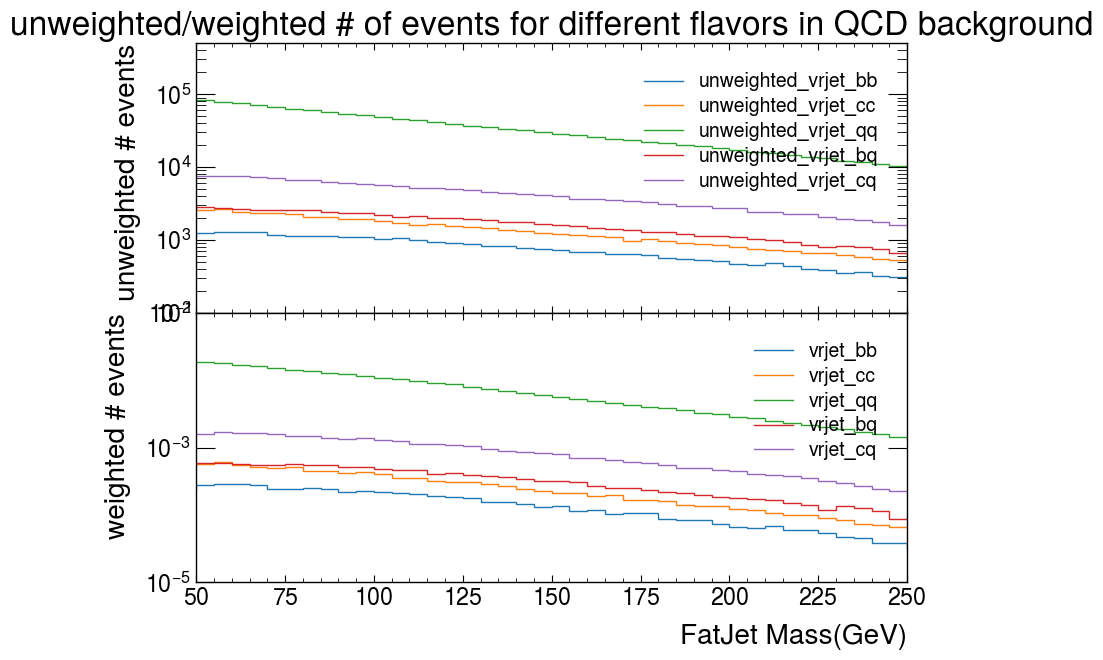

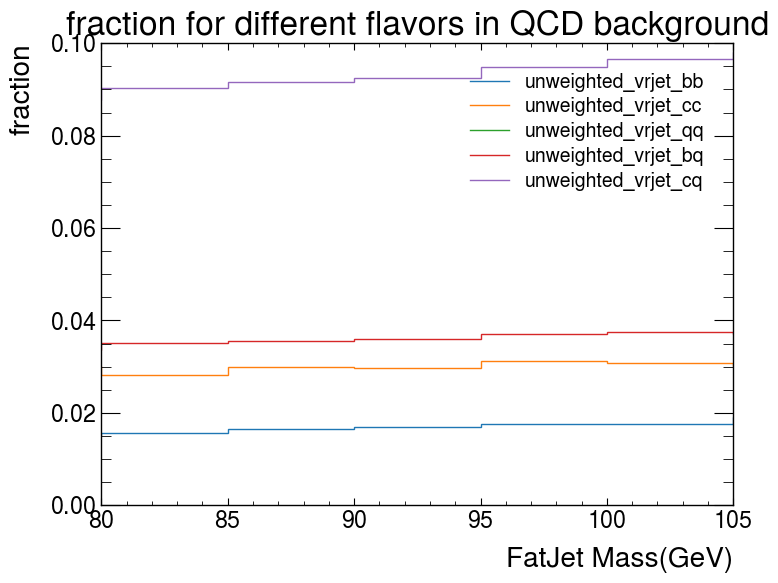

In [120]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1, 1]}, figsize=(9,7))
fig.subplots_adjust(hspace=0)
axs[0].stairs(unweighted_vrjet_histo_bb, edges, label='unweighted_vrjet_bb')
axs[0].stairs(unweighted_vrjet_histo_cc, edges, label='unweighted_vrjet_cc')
axs[0].stairs(unweighted_vrjet_histo_qq, edges, label='unweighted_vrjet_qq')
axs[0].stairs(unweighted_vrjet_histo_bq, edges, label='unweighted_vrjet_bq')
axs[0].stairs(unweighted_vrjet_histo_cq, edges, label='unweighted_vrjet_cq')

unweighted_vrjet_histo_tot = unweighted_vrjet_histo_bb + unweighted_vrjet_histo_cc + unweighted_vrjet_histo_qq + unweighted_vrjet_histo_bq + unweighted_vrjet_histo_cq
low_Z = np.where(edges==80)[0][0]
upper_Z = np.where(edges==105)[0][0]
#print(unweighted_vrjet_histo_bb)
#zip = np.stack(((fatjet_bb), (fatjet_cc), (fatjet_qq), (fatjet_bq), (fatjet_cq)), axis=-1)

#axs[1].hist(zip, edges, density=True, histtype='bar', stacked=True)

axs[1].stairs(vrjet_histo_bb, edges, label='vrjet_bb')
axs[1].stairs(vrjet_histo_cc, edges, label='vrjet_cc')
axs[1].stairs(vrjet_histo_qq, edges, label='vrjet_qq')
axs[1].stairs(vrjet_histo_bq, edges, label='vrjet_bq')
axs[1].stairs(vrjet_histo_cq, edges, label='vrjet_cq')

axs[1].set_xlabel('FatJet Mass(GeV)')
axs[0].set_ylabel('unweighted # events')
axs[0].set_title(r'unweighted/weighted # of events for different flavors in QCD background')
axs[1].set_ylabel('weighted # events')
axs[1].legend()
axs[0].legend()
axs[1].set_ylim(1e-5,.1)
axs[1].set_xlim(50, 250)
axs[1].set_yscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e2, .5e6)
#axs[0].set_xlim(80,110)
#axs[1].set_xlim(80,110)

########################################################### Fraction Histogram ####################################################################

vrjet_histo_tot = vrjet_histo_bb + vrjet_histo_cc + vrjet_histo_qq + vrjet_histo_bq + vrjet_histo_cq
unweighted_vrjet_histo_tot = unweighted_vrjet_histo_bb + unweighted_vrjet_histo_cc + unweighted_vrjet_histo_qq + unweighted_vrjet_histo_bq + unweighted_vrjet_histo_cq

#fig1, axs1 = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1, 1]}, figsize=(9,7))
fig1, axs1 = plt.subplots(1,1)
fig1.subplots_adjust(hspace=0)

bin_x = np.array([(2*i+dx)/2 for i in edges])

axs1.stairs(unweighted_vrjet_histo_bb/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bb')
axs1.stairs(unweighted_vrjet_histo_cc/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cc')
axs1.stairs(unweighted_vrjet_histo_qq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_qq')
axs1.stairs(unweighted_vrjet_histo_bq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bq')
axs1.stairs(unweighted_vrjet_histo_cq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cq')
#axs1.plot(bin_x[int((low_Z+upper_Z)/2)],(sum(histo_bb)*5/(edges[upper_Z]-edges[low_Z])),'b^', label='actual avg fraction of bb')
#axs1.plot(bin_x[int((low_Z+upper_Z)/2)],(sum(histo_cc)*5/(edges[upper_Z]-edges[low_Z])),'r^', label='actual avg fraction of cc')
axs1.set_ylabel('fraction')
axs1.set_title(r'fraction for different flavors in QCD background')
axs1.legend()
axs1.set_ylim(0,.1)
axs1.set_xlim(80,105)
axs1.set_xlabel('FatJet Mass(GeV)')

'''
axs1[0].stairs(unweighted_vrjet_histo_bb/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bb')
axs1[0].stairs(unweighted_vrjet_histo_cc/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cc')
axs1[0].stairs(unweighted_vrjet_histo_qq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_qq')
axs1[0].stairs(unweighted_vrjet_histo_bq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_bq')
axs1[0].stairs(unweighted_vrjet_histo_cq/unweighted_vrjet_histo_tot, edges, label='unweighted_vrjet_cq')
axs1[0].set_ylabel('unweighted fraction')
axs1[0].set_title(r'unweighted/weighted fraction for different flavors in QCD background')
axs1[0].legend()
axs1[0].set_yscale('log')
axs1[0].set_ylim(1e-2,2)

axs1[1].stairs(vrjet_histo_bb/vrjet_histo_tot, edges, label='vrjet_bb')
axs1[1].stairs(vrjet_histo_cc/vrjet_histo_tot, edges, label='vrjet_cc')
axs1[1].stairs(vrjet_histo_qq/vrjet_histo_tot, edges, label='vrjet_qq')
axs1[1].stairs(vrjet_histo_bq/vrjet_histo_tot, edges, label='vrjet_bq')
axs1[1].stairs(vrjet_histo_cq/vrjet_histo_tot, edges, label='vrjet_cq')

axs1[1].set_xlabel('FatJet Mass(GeV)')

axs1[1].set_ylabel('weighted fraction')
axs1[1].legend()

axs1[1].set_ylim(1e-2,2)
axs1[1].set_xlim(50, 250)
axs1[1].set_yscale('log')
'''


Comments: weighted and unweighted fraction don't have much difference, which makes sense since fraction can cancel out the weights

### Investigating the influence on the average value for fitting line with different ranges of integral
Motivation: Our signal region is 80-120 GeV for FJ Mass since the invariant mass for quarks should be around Z mass (~90 GeV). While our control region (area without signals) should be from 50-80 GeV and 120-250 GeV. The reason we choose 50-250 GeV is that we only look into resolved region instead of boosted region for Z->cc process.


Since vrjet_bb and vrjet_cc behave quite linearly in the range of 50-250 GeV FJ mass for the fraction plot, we will use $ax+b$ to fit the plot

In [33]:
#print(len(edges[np.where(edges==150):np.where(edges==300)]), len(vrjet_histo_bb))
print(np.where(edges==5)[0][0], np.where(edges==105))
print(np.array([(2*i+dx)/2 for i in edges])[0:10])
print(len(vrjet_histo_bb[30:60]))
print(sum(ydata_cc)*5/25)

1 (array([21]),)
[ 2.5  7.5 12.5 17.5 22.5 27.5 32.5 37.5 42.5 47.5]
30
0.24892216205727596


100 200
Hbb frac histo intergral in range of  80 to 105 is 1.5710 %
Hcc frac histo intergral in range of  80 to 105 is 2.9435 %
Hbb frac fitting intergral in range of  100 to 200 is 1.6435 %
Hcc frac fitting intergral in range of  100 to 200 is 2.8842 %
[2.97494311e-05 1.36091426e-02] [[ 3.77563726e-11 -5.66345596e-09]
 [-5.66345596e-09  8.80903390e-07]]
[3.93075687e-05 2.51076691e-02] [[ 9.82433596e-11 -1.47365039e-08]
 [-1.47365039e-08  2.29214038e-06]]


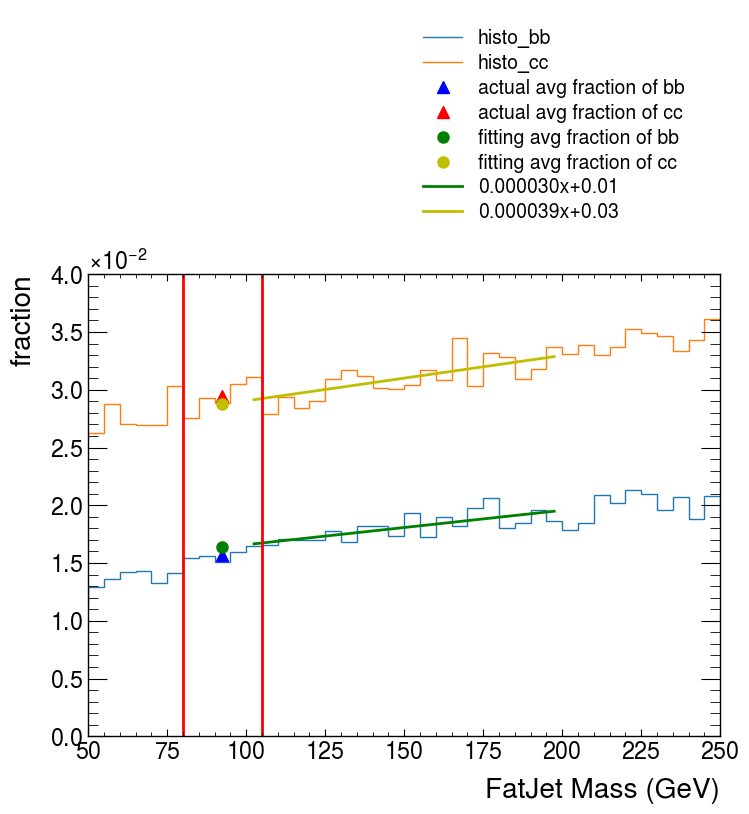

In [125]:
def func(x, a, b):
    return a * x + b 

# low_Z and upper_Z are the boundaries of the signal region
low_Z = np.where(edges==80)[0][0]
upper_Z = np.where(edges==105)[0][0]
# low and upper are the fitting region
low = np.where(edges==100)[0][0]
upper = np.where(edges==200)[0][0]

bin_x = np.array([(2*i+dx)/2 for i in edges])
xdata = bin_x[low:upper]
print(edges[low], edges[upper])
ydata_bb = (vrjet_histo_bb/vrjet_histo_tot)[low:upper] # bin content in the histogram in fitting region
histo_bb = (vrjet_histo_bb/vrjet_histo_tot)[low_Z:upper_Z] # bin content in the histogram in SR
print('Hbb frac histo intergral in range of ', edges[low_Z], 'to', edges[upper_Z], 'is %.4f'%(np.sum(histo_bb)*5/(edges[upper_Z]-edges[low_Z])*100), '%')
ydata_cc = (vrjet_histo_cc/vrjet_histo_tot)[low:upper]
histo_cc = (vrjet_histo_cc/vrjet_histo_tot)[low_Z:upper_Z]
print('Hcc frac histo intergral in range of ', edges[low_Z], 'to', edges[upper_Z], 'is %.4f'%(np.sum(histo_cc)*5/(edges[upper_Z]-edges[low_Z])*100), '%')
popt_bb, pcov_bb = curve_fit(func, xdata, ydata_bb)
print('Hbb frac fitting intergral in range of ', edges[low], 'to', edges[upper], 'is %.4f'%((popt_bb[0]/2*bin_x[upper_Z]**2+popt_bb[1]*bin_x[upper_Z]-popt_bb[0]/2*bin_x[low_Z]**2-popt_bb[1]*bin_x[low_Z])*100/(bin_x[upper_Z]-bin_x[low_Z])), '%')
popt_cc, pcov_cc = curve_fit(func, xdata, ydata_cc)
print('Hcc frac fitting intergral in range of ', edges[low], 'to', edges[upper], 'is %.4f'%((popt_cc[0]/2*bin_x[upper_Z]**2+popt_cc[1]*bin_x[upper_Z]-popt_cc[0]/2*bin_x[low_Z]**2-popt_cc[1]*bin_x[low_Z])*100/(bin_x[upper_Z]-bin_x[low_Z])), '%')

print(popt_bb, pcov_bb)
print(popt_cc, pcov_cc)
plt.stairs(vrjet_histo_bb/vrjet_histo_tot, edges, label='histo_bb')
plt.stairs(vrjet_histo_cc/vrjet_histo_tot, edges, label='histo_cc')
plt.plot(bin_x[int((low_Z+upper_Z)/2)],(np.sum(histo_bb)*5/(edges[upper_Z]-edges[low_Z])),'b^', label='actual avg fraction of bb')
plt.plot(bin_x[int((low_Z+upper_Z)/2)],(np.sum(histo_cc)*5/(edges[upper_Z]-edges[low_Z])),'r^', label='actual avg fraction of cc')
plt.plot(bin_x[int((low_Z+upper_Z)/2)],func(bin_x[int((low_Z+upper_Z)/2)], popt_bb[0], popt_bb[1]), 'go', label='fitting avg fraction of bb')
plt.plot(bin_x[int((low_Z+upper_Z)/2)],func(bin_x[int((low_Z+upper_Z)/2)], popt_cc[0], popt_cc[1]), 'yo', label='fitting avg fraction of cc')
plt.plot(bin_x[low:upper], func(bin_x[low:upper], *popt_bb), 'g-', label='%fx+%.2f'%(popt_bb[0], popt_bb[1]))
plt.plot(bin_x[low:upper], func(bin_x[low:upper], *popt_cc), 'y-', label='%fx+%.2f'%(popt_cc[0], popt_cc[1]))
ymax=0.04
dy=.01
plt.plot([80]*len(np.arange(0, ymax+dy, dy)), np.arange(0, ymax+dy, dy),'r-')
plt.plot([105]*len(np.arange(0, ymax+dy, dy)), np.arange(0, ymax+dy, dy),'r-')
plt.ylim(0, ymax)
plt.xlim(50, 250)
plt.xlabel('FatJet Mass (GeV)')
plt.ylabel('fraction')
plt.legend(bbox_to_anchor=(.99, 1.05))

### Awkward warm up tutorial

In [29]:
arr = ak.Array([[], [], [], [], [8.63], [11.9, 7.57], [], [], [], [], [1.8], [], [], [], [], [], []])
count_nonempty = sum(1 for sublist in arr if any(sublist))
b = [sublist for sublist in arr if any(sublist)]
#c = list(filter(bool, arr))
c = arr[ak.num(arr)>0]
print(c)
print(b)
print(count_nonempty)

[[8.63], [11.9, 7.57], [1.8]]
[<Array [8.63] type='1 * float64'>, <Array [11.9, 7.57] type='2 * float64'>, <Array [1.8] type='1 * float64'>]
3


In [96]:
a = ak.Array([[10.1], [13], [5.93], [11.5], [10.3]])
b = ak.Array([[5.36], [9.6], [16.2], [12.7], [10.6]])
c = ak.concatenate([a,b])
d = ak.flatten(c)
print(c)
print(ak.Array(d))

[[10.1], [13], [5.93], [11.5], [10.3], ..., [9.6], [16.2], [12.7], [10.6]]
[10.1, 13, 5.93, 11.5, 10.3, 5.36, 9.6, 16.2, 12.7, 10.6]


### Looking into the structure for branches and understading their meaning
Figure out what's vrjet like and vrjet cut information

In [29]:
id = ttree["vrJetIdFatJet"].array(library="ak")
qkid = ttree["vrJetHadronGhostTruthLabelID"].array(library="ak")
vrm = ttree["vrJetM"].array(library="ak")
vrpt = ttree["vrJetPt"].array(library="ak")
fjm = ttree["fatJetM"].array(library="ak")
MC = ttree["eventMCWeight"].array(library="ak")
#fjpt = ttree["fatJetPt"].array(library="ak")
fjpt = ttree["fatJetPt"].array(library="ak")
print("vrJetIdFatJet", id[3], id[50003]) # There're 3 vrjets in the leading fatjet, and 3 vrjets in the subleading fatjet for the 3rd event; There're 3 vrjets in nonfatjet for the 50003th event
print("vrJetHadronGhostTruthLabelID", qkid[3], qkid[50003]) # Specifically, 3 vrjets are light quarks in the leading fatjet while there are 2 b and 1 light quark in the subleading fatjet
print("MCweight", MC[:4])
print("vrJetM", vrm[3])
print("fatJetM", fjm[3])
print("fatJetPt", fjpt[:5])
print("vrJetPt", vrpt[3])
#print("fatJetPt", fjpt[:5])
print(min(ak.num(id, axis=1).to_numpy()))
print(min(ak.num(fjm, axis=1).to_numpy()))

vrJetIdFatJet [0, 0, 0, 1, 1, 1] [0, 0, 0, 0, 0, 1, 1, 2, 2, 2]
vrJetHadronGhostTruthLabelID [0, 0, 0, 4, 0, 4] [0, 0, 0, 0, 0, 0, 4, 0, 0, 0]
MCweight [2.07e-07, 2.82e-07, 1.89e-07, 8.81e-08]
vrJetM [2.01, 1.97, 4.28, 0.573, 0.978, 9.59]
fatJetM [19.4, 32.6]
fatJetPt [[615, 295], [434, 413], [526, 423], [543, 506], [728, 693]]
vrJetPt [7.74, 10, 239, 4.49, 6.36, 204]
0
0


In [5]:
#Print
branch_filter = {'fatJetGN2XHbb', 'fatJetGN2XHcc', 'fatJetGN2XQCD', 'fatJetPt', 'fatJetM', 'fatJetNCHadrons', 'fatJetNBHadrons', 'vrJetIdFatJet', 'vrJetHadronGhostTruthLabelID', 'vrJetPt', 'vrJetM'}

N = 5
for event, report in ttree.iterate(
    library="ak",
    step_size=N,
    entry_stop=N,
    filter_name=branch_filter,
    report=True,
):
    print('fatJetPt', event['fatJetPt'])

fatJetPt [[615, 295], [434, 413], [526, 423], [543, 506], [728, 693]]


Text(0, 1, 'fraction')

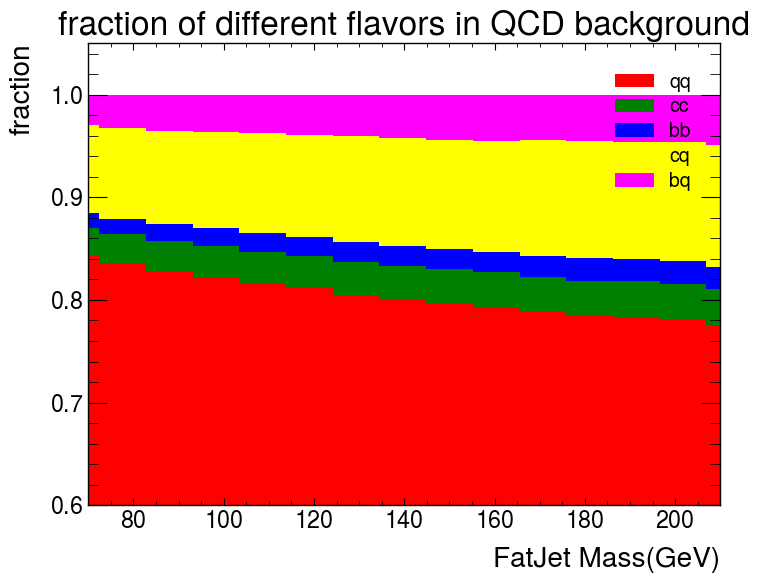

In [17]:
x = np.linspace(0, 600, len(vrjet_histo_bb))
label = ['qq', 'cc', 'bb', 'cq', 'bq']
c = ['red', 'green', 'blue', 'yellow', 'magenta']
plt.stackplot(x, vrjet_histo_qq/vrjet_histo_tot, (vrjet_histo_cc)/vrjet_histo_tot, (vrjet_histo_bb)/vrjet_histo_tot,\
              (vrjet_histo_cq)/vrjet_histo_tot, \
              (vrjet_histo_bq)/vrjet_histo_tot, step='post', labels=label, colors = c)
plt.legend()
plt.ylim(0.6, 1.05)
plt.xlim(70,210)
plt.xlabel('FatJet Mass(GeV)')
plt.title(r'fraction of different flavors in QCD background')
plt.ylabel('fraction')

1.81678655112866e-07
788.9090909090909


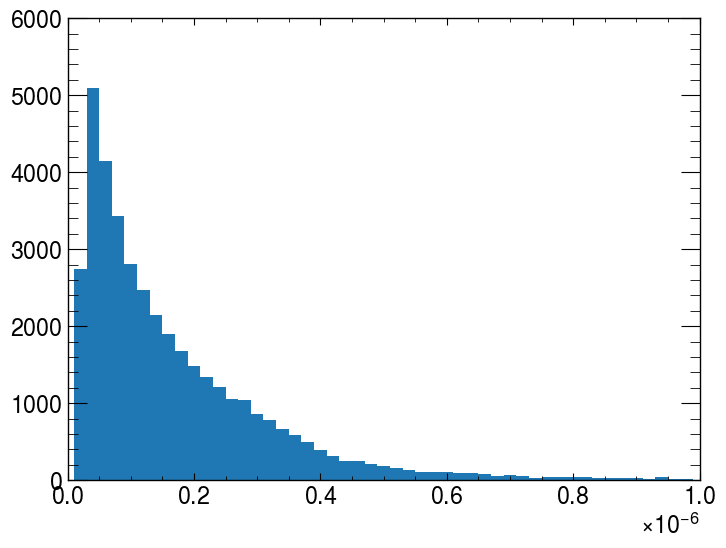

In [131]:
wbins = np.arange(1e-8, 1e-6, .2e-7)
content, e = np.histogram(weight_histo_bb, bins=wbins)
plt.hist(weight_histo_bb, bins=wbins)
print(np.average(weight_histo_bb))
print(np.sum(content)/(1e-6-1e-8)*.2e-7)

In [103]:
count =0
for entry in tqdm_notebook(tree, total=tree.GetEntries(), 
                         desc="Processing records"):
    print(tree.eventMCWeight)
    count +=1
    if count == 10:
        break

/tmp/ipykernel_3313293/1944650890.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for entry in tqdm_notebook(tree, total=tree.GetEntries(),


Processing records:   0%|          | 0/4078050 [00:00<?, ?it/s]

2.071877105436215e-07
2.815690152146999e-07
1.8911570975888026e-07
8.81275639130763e-08
4.5558010697277496e-08
4.279571328424936e-07
2.3476140142975055e-07
2.223339095053234e-07
1.6873462982402998e-07
1.7896115878102137e-07


## PyROOT Method
Note: It's slow to run PyROOT compared to UpROOT. So it would be wise to generate histograms and save them to a file and make plots separately.
### Generating Histograms

In [1]:
from ROOT import *
from tqdm import tqdm_notebook
file = TFile("/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root")
tree = file.Get('evttree')

QCD_bb = TH1F("QCD_bb_H_M", "QCD_bb", 40, 50, 250)
QCD_cc = TH1F("QCD_cc_H_M", "QCD_cc", 40, 50, 250)
QCD_bq = TH1F("QCD_bq_H_M", "QCD_bq", 40, 50, 250)
QCD_cq = TH1F("QCD_cq_H_M", "QCD_cq", 40, 50, 250)
QCD_qq = TH1F("QCD_qq_H_M", "QCD_qq", 40, 50, 250)

unweighted_QCD_bb = TH1F("unweighted_QCD_bb_H_M", "unweighted_QCD_bb", 40, 50, 250)
unweighted_QCD_cc = TH1F("unweighted_QCD_cc_H_M", "unweighted_QCD_cc", 40, 50, 250)
unweighted_QCD_bq = TH1F("unweighted_QCD_bq_H_M", "unweighted_QCD_bq", 40, 50, 250)
unweighted_QCD_cq = TH1F("unweighted_QCD_cq_H_M", "unweighted_QCD_cq", 40, 50, 250)
unweighted_QCD_qq = TH1F("unweighted_QCD_qq_H_M", "unweighted_QCD_qq", 40, 50, 250)
#print(tree.GetEntry(2))
#print(tree.vrJetPt)

count = 0
for entry in tqdm_notebook(tree, total=tree.GetEntries(), 
                         desc="Processing records"):
    Nb = 0
    Nc = 0
    Nq = 0
    for k in range(len(tree.vrJetIdFatJet)):
        if (tree.vrJetIdFatJet[k]==0) & (tree.vrJetPt[k]>20):
            if tree.vrJetHadronGhostTruthLabelID[k] == 5:
                Nb += 1
            elif tree.vrJetHadronGhostTruthLabelID[k] == 4:
                Nc += 1
            else:
                Nq += 1
    if Nb == 2:
        QCD_bb.Fill(tree.fatJetM[0], tree.eventMCWeight)
        unweighted_QCD_bb.Fill(tree.fatJetM[0])
    if Nc == 2:
        QCD_cc.Fill(tree.fatJetM[0], tree.eventMCWeight)
        unweighted_QCD_cc.Fill(tree.fatJetM[0])
    if (Nb == 1) & (Nq > 0):
        QCD_bq.Fill(tree.fatJetM[0], tree.eventMCWeight)
        unweighted_QCD_bq.Fill(tree.fatJetM[0])
    if (Nc == 1) & (Nq > 0):
        QCD_cq.Fill(tree.fatJetM[0], tree.eventMCWeight)
        unweighted_QCD_cq.Fill(tree.fatJetM[0])
    if (Nb == 0) & (Nc == 0) & (Nq > 1):
        QCD_qq.Fill(tree.fatJetM[0], tree.eventMCWeight)
        unweighted_QCD_qq.Fill(tree.fatJetM[0])

QCD_tot = TH1F("QCD_tot_H_M", "QCD_tot", 40, 50, 250)
QCD_tot.Add(QCD_bb, QCD_cc)
QCD_tot.Add(QCD_bq)
QCD_tot.Add(QCD_cq)
QCD_tot.Add(QCD_qq)

unweighted_QCD_tot = TH1F("unweighted_QCD_tot_H_M", "unweighted_QCD_tot", 40, 50, 250)
unweighted_QCD_tot.Add(unweighted_QCD_bb, unweighted_QCD_cc)
unweighted_QCD_tot.Add(unweighted_QCD_bq)
unweighted_QCD_tot.Add(unweighted_QCD_cq)
unweighted_QCD_tot.Add(unweighted_QCD_qq)

Warning in <TInterpreter::ReadRootmapFile>: class  HepMC3::FourVector found in libGeneratorObjectsDict.so  is already in libHepMC3rootIO.so 
Warning in <TInterpreter::ReadRootmapFile>: class  HepMC::FourVector found in libGeneratorObjectsDict.so  is already in libHepMC3rootIO.so 


Welcome to JupyROOT 6.28/12


/lscratch/dliu64/tmp/ipykernel_3251528/1133693606.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for entry in tqdm_notebook(tree, total=tree.GetEntries(),


Processing records:   0%|          | 0/4078050 [00:00<?, ?it/s]

True

### Save histograms in a new root file

In [2]:
histo_list = []

histo_list.append(unweighted_QCD_bb)
histo_list.append(unweighted_QCD_cc)
histo_list.append(unweighted_QCD_bq)
histo_list.append(unweighted_QCD_cq)
histo_list.append(unweighted_QCD_qq)
histo_list.append(unweighted_QCD_tot)
histo_list.append(QCD_bb)
histo_list.append(QCD_cc)
histo_list.append(QCD_bq)
histo_list.append(QCD_cq)
histo_list.append(QCD_qq)
histo_list.append(QCD_tot)

name_list = []
name_list.append("unweighted_QCD_bb")
name_list.append("unweighted_QCD_cc")
name_list.append("unweighted_QCD_bq")
name_list.append("unweighted_QCD_cq")
name_list.append("unweighted_QCD_qq")
name_list.append("unweighted_QCD_tot")
name_list.append("QCD_bb")
name_list.append("QCD_cc")
name_list.append("QCD_bq")
name_list.append("QCD_cq")
name_list.append("QCD_qq")
name_list.append("QCD_tot")
print(histo_list[0])

with TFile.Open("QCD_flavor_fraction_Histograms.root", "recreate") as f:
    print("Current directory: '{}'.\n".format(gDirectory.GetName()))
    print("Histogram '{}' is attached to: '{}'.\n".format(unweighted_QCD_bb.GetName(), unweighted_QCD_bb.GetDirectory().GetName()))
    for i in range(len(histo_list)):
        f.WriteObject(histo_list[i], name_list[i])

Name: unweighted_QCD_bb_H_M Title: unweighted_QCD_bb NbinsX: 40
Current directory: 'QCD_flavor_fraction_Histograms.root'.

Histogram 'unweighted_QCD_bb_H_M' is attached to: '/fs/ddn/sdf/group/ldmx/users/dongyi/Higgs/evttree-mc23_13p6TeV.801169.Py8EG_A14NNPDF23LO_jj_JZ4.deriv.DAOD_PHYS.e8514_s4159_r14799_p5855.root'.



### Read and name histogram from the new ROOT file

In [2]:
from ROOT import *
import numpy as np

histo_file = TFile('QCD_flavor_fraction_Histograms.root')
histo_file.ls()
unweighted_QCD_bb = histo_file.Get('unweighted_QCD_bb')
unweighted_QCD_cc = histo_file.Get('unweighted_QCD_cc')
unweighted_QCD_bq = histo_file.Get('unweighted_QCD_bq')
unweighted_QCD_cq = histo_file.Get('unweighted_QCD_cq')
unweighted_QCD_qq = histo_file.Get('unweighted_QCD_qq')
unweighted_QCD_tot = histo_file.Get('unweighted_QCD_tot')

TFile**		Histograms.root	
 TFile*		Histograms.root	
  KEY: TH1F	unweighted_QCD_bb;1	unweighted fraction of different flavors in QCD background
  KEY: TH1F	unweighted_QCD_cc;1	unweighted_QCD_cc
  KEY: TH1F	unweighted_QCD_bq;1	unweighted_QCD_bq
  KEY: TH1F	unweighted_QCD_cq;1	unweighted_QCD_cq
  KEY: TH1F	unweighted_QCD_qq;1	unweighted_QCD_qq
  KEY: TH1F	unweighted_QCD_tot;1	unweighted_QCD_tot
  KEY: TH1F	QCD_bb;1	QCD_bb
  KEY: TH1F	QCD_cc;1	QCD_cc
  KEY: TH1F	QCD_bq;1	QCD_bq
  KEY: TH1F	QCD_cq;1	QCD_cq
  KEY: TH1F	QCD_qq;1	QCD_qq
  KEY: TH1F	QCD_tot;1	QCD_tot


In [195]:
import statistics as stat
un_sumw2=np.array(un_bb.GetSumw2())
#un_sumw2=np.array(unweighted_QCD_bq.GetSumw2())
sumw2=np.array(QCD_bb.GetSumw2())
print(un_sumw2)
print(unweighted_QCD_bb.GetSumw2N())
print(len(un_sumw2))

[4122. 1245. 1282. 1268. 1277. 1177. 1139. 1135. 1132. 1106. 1096. 1039.
 1078.  999.  938.  919.  885.  832.  835.  781.  749.  726.  688.  678.
  639.  634.  630.  572.  549.  526.  521.  470.  459.  476.  437.  403.
  383.  354.  362.  322.  312. 4442.]
42
42


### Make plots of # of events

bb bin error 35.805027579936315
bb bin content 1282.0
tot bin error 304.9032633475739
tot bin content 92966.0
TH1.Print Name  = unweighted_QCD_bb_H_M, Entries= 39617, Total sum= 31053
TH1.Print Name  = unweighted_QCD_cc_H_M, Entries= 72261, Total sum= 54549
TH1.Print Name  = unweighted_QCD_bq_H_M, Entries= 90223, Total sum= 66918
TH1.Print Name  = unweighted_QCD_cq_H_M, Entries= 232453, Total sum= 171756
TH1.Print Name  = unweighted_QCD_qq_H_M, Entries= 2019228, Total sum= 1.41414e+06
TH1.Print Name  = unweighted_QCD_tot_H_M, Entries= 2453782, Total sum= 1.73841e+06


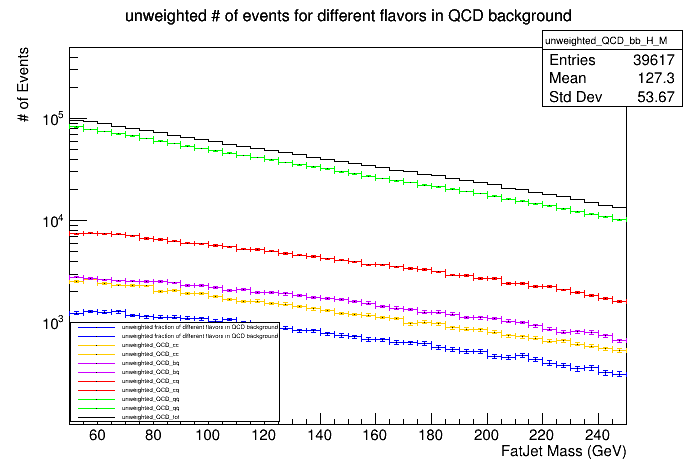

In [3]:

c0 = TCanvas()
c0.Draw()
unweighted_QCD_bb.Print()
print('bb bin error', unweighted_QCD_bb.GetBinError(2))
print('bb bin content', unweighted_QCD_bb.GetBinContent(2))
#print(unweighted_QCD_bb.GetSumw2N())
print('tot bin error', unweighted_QCD_tot.GetBinError(2))
print('tot bin content', unweighted_QCD_tot.GetBinContent(2))
unweighted_QCD_bb.SetLineColor(kBlue)
unweighted_QCD_bb.Draw('histo same')
unweighted_QCD_bb.Draw('E1 same')
unweighted_QCD_cc.Print()
unweighted_QCD_cc.SetLineColor(kOrange)
unweighted_QCD_cc.Draw('histo same')
unweighted_QCD_cc.Draw('E1 same')
unweighted_QCD_bq.Print()
unweighted_QCD_bq.SetLineColor(kViolet)
unweighted_QCD_bq.Draw('histo same')
unweighted_QCD_bq.Draw('E1 same')
unweighted_QCD_cq.Print()
unweighted_QCD_cq.SetLineColor(kRed)
unweighted_QCD_cq.Draw('histo same')
unweighted_QCD_cq.Draw('E1 same')
unweighted_QCD_qq.Print()
unweighted_QCD_qq.SetLineColor(kGreen)
unweighted_QCD_qq.Draw('histo same')
unweighted_QCD_qq.Draw('E1 same')

unweighted_QCD_tot.Print()
unweighted_QCD_tot.SetLineColor(kBlack)
unweighted_QCD_tot.Draw('histo same')

unweighted_QCD_bb.GetYaxis().SetRangeUser(1e2, .5e6)
c0.SetLogy()
c0.BuildLegend()
unweighted_QCD_bb.GetXaxis().SetTitle('FatJet Mass (GeV)')
unweighted_QCD_bb.GetYaxis().SetTitle('# of Events')
unweighted_QCD_bb.SetTitle("unweighted # of events for different flavors in QCD background")


In [16]:
print(unweighted_QCD_bb.GetBinCenter(1))

52.5


In [32]:
def func(x, a, b):
    return a * x + b 
sumw = np.array(unweighted_QCD_bb.GetSumw2())
N = unweighted_QCD_bb.GetNbinsX()
bin_bb = 0
fit_bb = 0
for i in range(len(sumw)-1):
    bin_bb += unweighted_frac_bb.GetBinContent(i+1)
    fit_bb += func(unweighted_QCD_bb.GetBinCenter(i+1), 5.64061e-05, 1.11176e-02)
print(bin_bb/200*5)
print(fit_bb/200*5)




0.020095503097400068
0.020212518506249996


### Plots of unweighted fraction
Note: Remember to add func.Sumw2() before plotting to activate the error so the error propagation could be done correctly
#### Error propagation Validation
$$\sigma_{tot}^2=(\frac{\partial f}{\partial x}\sigma_x)^2+(\frac{\partial f}{\partial y}\sigma_y)^2$$
In our case, we are calculating the fraction $\frac{N_{bb}}{N_{tot}}$. Thus, the total error should be
$$\sigma_{frac}^2=(\frac{1}{N_{tot}}\sigma_{N_{bb}})^2+(\frac{N_{bb}}{N_{tot}^2}\sigma_{N_{tot}})^2$$
Since $\sigma_{N_{bb}}=\sqrt{N_{bb}}$, $\sigma_{N_{tot}}=\sqrt{N_{tot}}$, the Eq above should be
$$\sigma_{frac}^2=\frac{N_{bb}}{N_{tot}^3}(N_{tot}+N_{bb})$$

In [19]:
num=1
Nbb=unweighted_QCD_bb.GetBinContent(num)
Ntot=unweighted_QCD_tot.GetBinContent(num)
unweighted_QCD_tot.Sumw2() # Add Sumw2() everywhere to make sure it activates the error term
unweighted_QCD_bb.Sumw2()

print('Nbb', Nbb, 'sqrt(Nbb)', np.sqrt(Nbb))
print('Ntot', Ntot, 'sqrt(Ntot)', np.sqrt(Ntot))
# Verify that sigma is indeed sqrt(N)
print('bb # of events bin error', unweighted_QCD_bb.GetBinError(1))
print('tot # of events bin error', unweighted_QCD_tot.GetBinError(1))

print(r'bb # of events for the %i bin'%num, Nbb)
print(r'tot # of events for the %i bin'%num, unweighted_QCD_tot.GetBinContent(num), Ntot)
print(r'theoretical value for sigma_{frac}', np.sqrt(Nbb/Ntot**3*(Nbb+Ntot)))

Nbb 1245.0 sqrt(Nbb) 35.2845575287547
Ntot 96713.0 sqrt(Ntot) 310.98713799769916
bb # of events bin error 35.2845575287547
tot # of events bin error 310.98713799769916
bb # of events for the 1 bin 1245.0
tot # of events for the 1 bin 96713.0 96713.0
theoretical value for sigma_{frac} 0.0003671785883248247


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


In [81]:
def func(x, a, b):
    return a*x+b
bin_edges = y[1]
ycenter = (bin_edges[:-1]+bin_edges[1:])/2
popt, pcov = curve_fit(func, ycenter, y[0])
print(np.mean(y[0]))
sum=0
for i in range(len(y[0])):
    sum += (y[0][i]-np.mean(y[0]))**2/np.mean(y[0])
print(popt)
print(sum)

2.8
[ 8.0000000e-01 -2.1813662e-12]
2.428571428571429


/tmp/ipykernel_171631/874529837.py:5: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, ycenter, y[0])


[1 2 3 4 4]
histo_y 1.0
fit_y 1.0865191146883897
histo_y 2.0
fit_y 1.93158953722367
histo_y 3.0
fit_y 2.776659959758951
histo_y 4.0
fit_y 3.6217303822942313
histo_y 4.0
fit_y 4.466800804829512
0.10575930431683898
0.11670020120724339
 FCN=0.1167 FROM MIGRAD    STATUS=CONVERGED      31 CALLS          32 TOTAL
                     EDM=7.29146e-24    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.45070e-01   4.74713e-01   1.09801e-04   1.07432e-11
   2  p1          -1.81087e-01   1.46041e+00   3.37792e-04   1.02709e-12


Warning in <TFile::Append>: Replacing existing TH1: histo_test (Potential memory leak).


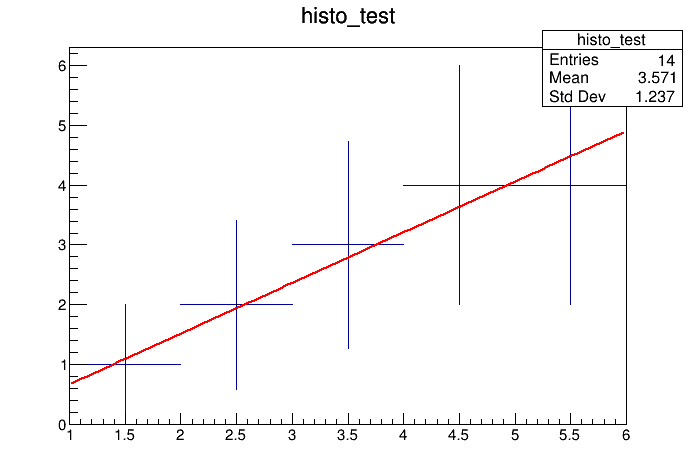

In [78]:
x = np.array([1, 2, 3, 4, 5, 6])
data_y = np.array([1, 2,2,3,3,3,4,4,4,4,5,5,5, 5])
y = np.histogram(data_y, bins=x)
print(y[0])
pol1 = TF1("test","[0]*x+[1]",1, 6)
histo = TH1F("histo_test", "histo_test", 5, 1, 6)
histo.Sumw2()
for i in range(len(data_y)):
    histo.Fill(data_y[i],1)
histo.Fit('test','','',1,6)
pol1.GetParError

var = 0
for i in range(1, 6):
    histo_y = histo.GetBinContent(i)
    print('histo_y', histo_y)
    error_y = histo.GetBinError(i)
    x = histo.GetBinCenter(i)
    #histo.SetBinError(i,1)
    fit_y = x*pol1.GetParameter(0) + pol1.GetParameter(1)
    print('fit_y', fit_y)
    var += (fit_y-histo_y)**2
    #print('chi2', chi2)
print(var/4)
print(pol1.GetChisquare())
c0 = TCanvas()
c0.Draw()
histo.Draw()

In [30]:
print(fit_bb_func.GetParameter(0))
print(fit_bb_func.GetParameter(1))
print(fit_bb_func.GetChisquare())
chi2=0
for i in range(1, 7):
    histo_y = unweighted_frac_bb.GetBinContent(i)
    print('histo_y', histo_y)
    error_y = unweighted_frac_bb.GetBinError(i)
    x = unweighted_frac_bb.GetBinCenter(i)
    fit_y = x*fit_bb_func.GetParameter(0) + fit_bb_func.GetParameter(1)
    print('fit_y', fit_y)
    chi2 += (fit_y-histo_y)**2/error_y*5
    print('chi2', chi2)
    
print(chi2)

8.184035660220695e-05
0.00894513972449608
4.9953379432125775
histo_y 0.012873140163719654
fit_y 0.013241758446111945
chi2 0.0018503181072426415
histo_y 0.013789988122880459
fit_y 0.013650960229122981
chi2 0.002099536462051116
histo_y 0.01428893394768238
fit_y 0.014060162012134015
chi2 0.00274705834727542
histo_y 0.01514450740069151
fit_y 0.01446936379514505
chi2 0.008084568165974033
histo_y 0.014578920789062977
fit_y 0.014878565578156085
chi2 0.00913339407122758
histo_y 0.0149571243673563
fit_y 0.01528776736116712
chi2 0.010357667867139535
0.010357667867139535


In [40]:
R.GetCovarianceMatrix().Print()
print(np.mean(y))

7.0

2x2 matrix is as follows

     |      0    |      1    |
-------------------------------
   0 |       0.42       -1.05 
   1 |      -1.05        3.15 



In [68]:
syy=0
sxy=0
sxx=0
for i in range(N):
    syy += (y[i]-7)**2
    sxy += (y[i]-7)*(x[i]-2.5)
    sxx += (x[i]-2.5)**2
x2N=sxx+N*2.5**2
syy/=N
sxy/=N
sxx/=N
sigma=4.2/2
print('b',sxy/sxx)
print('a',7-sxy/sxx*2.5)
print(np.sqrt(sigma/sxx)/2)
print(np.sqrt(sigma*(x2N/sxx/4))/2)


b 1.4
a 3.5
0.6480740698407861
1.7748239349298849


In [37]:
wy=0
wy2=0
wx=0
wx2=0
wxy=0
N=4
w=1/ey[:N]**2
xbar=np.mean(x)
ybar=np.mean(y)
for i in range(N):
    wx2 += w[i]*x[i]**2
    wx += w[i]*x[i]
    wy2 += w[i]*y[i]**2
    wy += w[i]*y[i]
    wxy +=w[i]*y[i]*x[i]
    
swxx=wx2-wx**2/np.sum(w)
swxy=wxy-wx*wy/np.sum(w)
b=swxy/swxx
a=(wy-swxy/swxx*wx)/np.sum(w)
print('b', swxy/swxx)
print('a', (wy-swxy/swxx*wx)/np.sum(w))
chi=0
#b= 8.56903e-05
#a = 8.70056e-03
for i in range(N):
    chi += (y[i]-(a+b*x[i]))**2*w[i]
print(chi/2)

b 1.6382059054676086
a 2.881609969686766
4.600314359492534


iminuit version: 2.25.2


'\nfit_func = TF1("fit_func","[0]*x+[1]",1, 4)\nN = 4\n\nc1 = TCanvas( \'c1\', \'A Simple Graph with error bars\', 200, 10, 700, 500 )\nc1.Draw()\ngr = TGraphErrors(N, x, y, ex, ey)\nfitter=ROOT.Fit.Fitter \n#fitter.LeastSquareFit(x, y)\ngr.SetMarkerColor( 4 )\ngr.SetMarkerStyle( 21 )\nR= gr.Fit(fit_func, \'S\', \'\', 1, 4)\ngr.Draw( \'ALP same\' )'

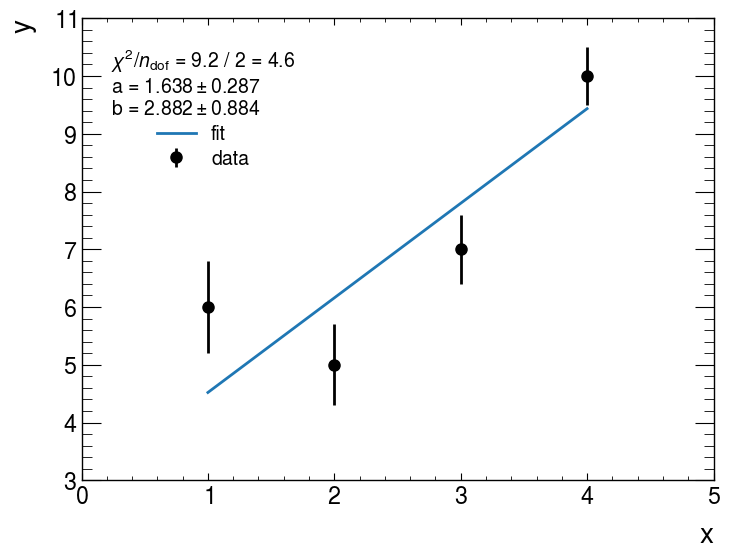

In [38]:
from array import array
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

# display iminuit version
import iminuit
print("iminuit version:", iminuit.__version__)

x  = np.array([ 1, 2, 3, 4 ], dtype=float )
y  = np.array([ 6, 5, 7, 10 ], dtype=float )
ey = np.array([  0.8,  0.7,  0.6,  0.5  ], dtype=float )
ex = np.array([  .5,  .5,  .5,  .5  ], dtype=float )

least_squares = LeastSquares(x, y, ey, func)

m = Minuit(least_squares, a=0, b=0)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()   # accurately computes uncertainties

# draw data and fitted line
plt.errorbar(x, y, ey, fmt="ok", label="data")
plt.plot(x, func(x, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info), frameon=False)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 5)

'''
fit_func = TF1("fit_func","[0]*x+[1]",1, 4)
N = 4

c1 = TCanvas( 'c1', 'A Simple Graph with error bars', 200, 10, 700, 500 )
c1.Draw()
gr = TGraphErrors(N, x, y, ex, ey)
fitter=ROOT.Fit.Fitter 
#fitter.LeastSquareFit(x, y)
gr.SetMarkerColor( 4 )
gr.SetMarkerStyle( 21 )
R= gr.Fit(fit_func, 'S', '', 1, 4)
gr.Draw( 'ALP same' )'''


0.016867199912667274


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


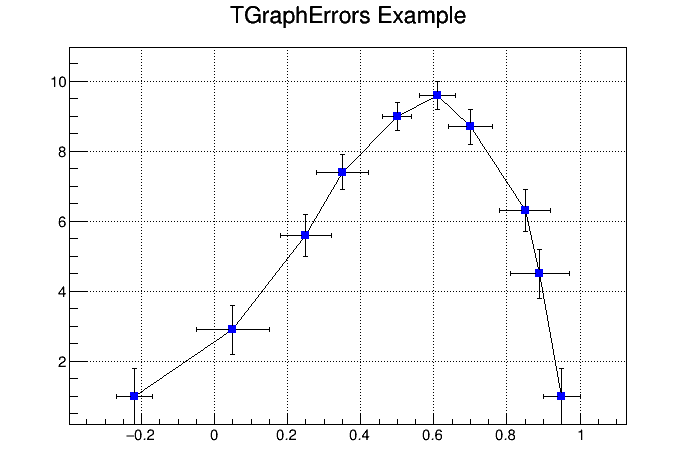

In [43]:
from array import array
 
c1 = TCanvas( 'c1', 'A Simple Graph with error bars', 200, 10, 700, 500 )
c1.Draw()
c1.SetGrid()
c1.GetFrame().SetFillColor( 21 )
c1.GetFrame().SetBorderSize( 12 )
 
n = 10;
x  = array( 'f', [ -0.22, 0.05, 0.25, 0.35,  0.5, 0.61,  0.7, 0.85, 0.89, 0.95 ] )
ex = array( 'f', [  0.05,  0.1, 0.07, 0.07, 0.04, 0.05, 0.06, 0.07, 0.08, 0.05 ] )
y  = array( 'f', [     1,  2.9,  5.6,  7.4,  9.0,  9.6,  8.7,  6.3,  4.5,    1 ] )
ey = array( 'f', [  0.8,  0.7,  0.6,  0.5,  0.4,  0.4,  0.5,  0.6,  0.7,  0.8  ] )
 
gr = TGraphErrors( n, x, y, ex, ey )
gr.SetTitle( 'TGraphErrors Example' )
gr.SetMarkerColor( 4 )
gr.SetMarkerStyle( 21 )
gr.Draw( 'ALP same' )


### Pre-Calculation
#### How to Calculate Actual Avg Fraction?
- Sum all the bins contents (y values for each bin) in SR
- Divided by the number of bins in SR
- $\frac{\sum_i^{N_{SR}}y_i}{N_{SR}}$

#### How to Calculate error for it?
- Square all the bins errors in SR and sum them up
- Divided by the number of bins in SR
- Take square root of it
- $\sqrt{\frac{\sum_i^{N_{SR}}\sigma_i^2}{N_{SR}}}$


In [113]:
chi=0
#b= 8.56903e-05
#a = 8.70056e-03
for i in range(N):
    chi += (y[i]-(a+b*x[i]))**2*w[i]
print(chi)

11.260461754955013


In [42]:
wy=0
wy2=0
wx=0
wx2=0
wxy=0
N=6
x=bin_x[:N]
y = bin_y_bb[:N]
w=1/(err_y_bb[:N]**2)
xbar=np.mean(x)
ybar=np.mean(y)
for i in range(N):
    wx2 += w[i]*x[i]**2
    wx += w[i]*x[i]
    wy2 += w[i]*y[i]**2
    wy += w[i]*y[i]
    wxy +=w[i]*y[i]*x[i]
    
swxx=wx2-wx**2/np.sum(w)
swxy=wxy-wx*wy/np.sum(w)
b=swxy/swxx
a=(wy-swxy/swxx*wx)/np.sum(w)
print('b', swxy/swxx)
print('a', (wy-swxy/swxx*wx)/np.sum(w))

b 8.184035660220542e-05
a 0.008945139724496088


In [4]:
# Generating fraction histograms
unweighted_QCD_tot.Sumw2() # Add Sumw2() everywhere to make sure it activates the error term
unweighted_QCD_bb.Sumw2()
unweighted_QCD_cc.Sumw2()
unweighted_frac_bb = unweighted_QCD_bb.Clone()
unweighted_frac_bb.Divide(unweighted_QCD_tot)
unweighted_frac_cc = unweighted_QCD_cc.Clone()
unweighted_frac_cc.Divide(unweighted_QCD_tot)

# Initialization for histograms
N = unweighted_frac_bb.GetNbinsX()
N+=1
bin_x = np.array([0.0]*(N-1))
bin_y_bb = np.array([0.0]*(N-1))
err_x = np.array([0.0]*(N-1))
err_y_bb = np.array([0.0]*(N-1))
bin_y_cc = np.array([0.0]*(N-1))
err_y_cc = np.array([0.0]*(N-1))
for i in range(1, N):
    bin_x[i-1]=(unweighted_frac_bb.GetBinCenter(i))
    bin_y_bb[i-1]=(unweighted_frac_bb.GetBinContent(i))
    bin_y_cc[i-1]=(unweighted_frac_cc.GetBinContent(i))
    err_x[i-1]=2.5
    err_y_bb[i-1]=(unweighted_frac_bb.GetBinError(i))
    err_y_cc[i-1]=(unweighted_frac_cc.GetBinError(i))

# Initialization of histogram actual Avg fraction dot in SR
histo_avg_frac_bb=np.sum(bin_y_bb[int((80-50)/5):int((105-50)/5)])*5/25
histo_avg_frac_cc=np.sum(bin_y_cc[int((80-50)/5):int((105-50)/5)])*5/25
histo_var_frac_bb=np.sum(err_y_bb[int((80-50)/5):int((105-50)/5)]**2)*5/25
histo_var_frac_cc=np.sum(err_y_cc[int((80-50)/5):int((105-50)/5)]**2)*5/25

print('actual Avg bb fraction = %f +- %f '%(histo_avg_frac_bb*100, np.sqrt(histo_var_frac_bb)*100), '%')
print('actual Avg cc fraction = %f +- %f '%(histo_avg_frac_cc*100, np.sqrt(histo_var_frac_cc)*100), '%')

histo_avg_frac_bb = np.array(histo_avg_frac_bb, dtype=float)
histo_avg_frac_cc = np.array(histo_avg_frac_cc, dtype=float)
histo_err_frac_bb = np.array(np.sqrt(histo_var_frac_bb), dtype=float)
histo_err_frac_cc = np.array(np.sqrt(histo_var_frac_cc), dtype=float)

actual Avg bb fraction = 1.686720 +- 0.051380  %
actual Avg cc fraction = 2.997014 +- 0.068899  %


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


### Making Plots of fraction

 FCN=3.97959 FROM MIGRAD    STATUS=CONVERGED      83 CALLS          84 TOTAL
                     EDM=4.34886e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.56903e-05   2.22375e-05   3.17308e-09   1.17572e+02
   2  p1           8.70056e-03   1.43788e-03   2.05230e-07   1.19931e+00
 FCN=8.99991 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=2.94461e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.22652e-04   3.37499e-05   6.37200e-09   8.35617e+00
   2  p1           2.01584e-02   2.18372e-03   4.12259e-07   1.59575e-01


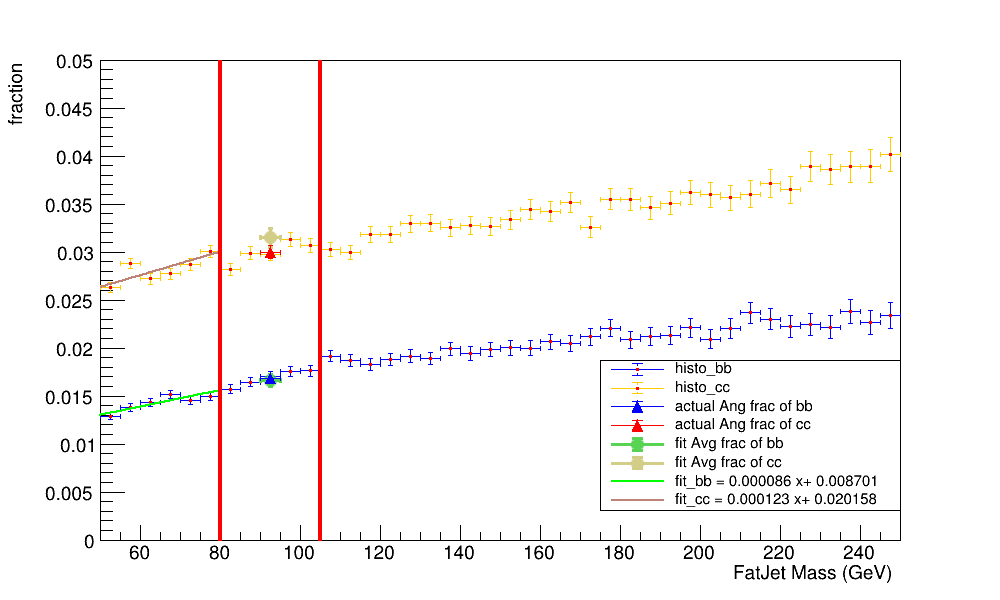

In [5]:
cnew=TCanvas()
cnew.SetCanvasSize(1000, 600)
mg = TMultiGraph()
cnew.Draw()

# Plot Histograms
histo_bb=TGraphErrors(N, bin_x, bin_y_bb, err_x, err_y_bb)
histo_bb.SetMarkerStyle(7)
histo_bb.SetLineColor(kBlue)
histo_bb.SetMarkerColor(kRed)

histo_cc=TGraphErrors(N, bin_x, bin_y_cc, err_x, err_y_cc)
histo_cc.SetMarkerStyle(7) # https://root.cern.ch/doc/master/classTAttMarker.html
histo_cc.SetLineColor(kOrange) # https://root.cern.ch/doc/master/classTColor.html
histo_cc.SetMarkerColor(2)

mg.GetXaxis().SetTitle('FatJet Mass (GeV)')
mg.GetYaxis().SetTitle('fraction')

# Fitting Function
fit_bb_func = TF1("fit_bb","[0]*x+[1]",50, 250)
fit_cc_func = TF1("fit_cc","[0]*x+[1]",50, 250)
fit_bb_func.SetLineColor(kGreen)
fit_cc_func.SetLineColor(45)

# Fitting Range
fr_low=50
fr_high=80

prt_fit_bb = histo_bb.Fit('fit_bb','S','', fr_low, fr_high)
prt_fit_cc = histo_cc.Fit('fit_cc','S','', fr_low, fr_high)

# Plot histogram actual Avg fraction dot in SR
ex = np.array([2.5], dtype=float)
x = np.array([92.5], dtype=float)

actual_avg_frac_bb=TGraphErrors(1, x, histo_avg_frac_bb, ex, histo_err_frac_bb)
actual_avg_frac_bb.SetMarkerStyle(22)
actual_avg_frac_bb.SetLineColor(4)
actual_avg_frac_bb.SetMarkerColor(4)
actual_avg_frac_bb.SetMarkerSize(1.5)
#actual_avg_frac_bb.SetLineWidth(3)

actual_avg_frac_cc=TGraphErrors(1, x, histo_avg_frac_cc, ex, histo_err_frac_cc)
actual_avg_frac_cc.SetMarkerStyle(22)
actual_avg_frac_cc.SetLineColor(2)
actual_avg_frac_cc.SetMarkerColor(2)
actual_avg_frac_cc.SetMarkerSize(1.5)
#actual_avg_frac_cc.SetLineWidth(3)


# Initilization of a single fitting fraction dot in SR
p1_bb = prt_fit_bb.Parameter(0)
p2_bb = prt_fit_bb.Parameter(1)
err_p1_bb = prt_fit_bb.ParError(0)
err_p2_bb = prt_fit_bb.ParError(1)
sigma2_p1_bb = prt_fit_bb.CovMatrix(0,0)
sigma2_p2_bb = prt_fit_bb.CovMatrix(1,1)
sigma_p12_bb = prt_fit_bb.CovMatrix(0,1)
p1_cc = prt_fit_cc.Parameter(0)
p2_cc = prt_fit_cc.Parameter(1)
err_p1_cc = prt_fit_cc.ParError(0)
err_p2_cc = prt_fit_cc.ParError(1)
sigma2_p1_cc = prt_fit_cc.CovMatrix(0,0)
sigma2_p2_cc = prt_fit_cc.CovMatrix(1,1)
sigma_p12_cc = prt_fit_cc.CovMatrix(0,1)

fit_y_bb = np.array([92.5*prt_fit_bb.Parameter(0)+prt_fit_bb.Parameter(1)], dtype=float)
eyl_bb = np.array([fit_y_bb - (92.5*(prt_fit_bb.Parameter(0)-prt_fit_bb.ParError(0))+prt_fit_bb.Parameter(1)-prt_fit_bb.ParError(1))], dtype=float)
eyh_bb = np.array([(92.5*(prt_fit_bb.Parameter(0)+prt_fit_bb.ParError(0))+prt_fit_bb.Parameter(1)+prt_fit_bb.ParError(1)) - fit_y_bb], dtype=float)
#fit_avg_frac_bb = TGraphAsymmErrors(1, x, fit_y_bb, ex, ex, eyl_bb, eyh_bb)
fit_avg_frac_bb = TGraphErrors(1, x, fit_y_bb, ex, np.array([np.sqrt((2312.5/25)**2*sigma2_p1_bb+sigma2_p2_bb+2*2312.5/25*sigma_p12_bb)], dtype=float))
fit_avg_frac_bb.SetMarkerStyle(8)
fit_avg_frac_bb.SetLineColor(8)
fit_avg_frac_bb.SetMarkerColor(8)
fit_avg_frac_bb.SetMarkerSize(1.5)
fit_avg_frac_bb.SetLineWidth(3)

fit_y_cc = np.array([92.5*prt_fit_cc.Parameter(0)+prt_fit_cc.Parameter(1)], dtype=float)
eyl_cc = np.array([fit_y_cc - (92.5*(prt_fit_cc.Parameter(0)-prt_fit_cc.ParError(0))+prt_fit_cc.Parameter(1)-prt_fit_cc.ParError(1))], dtype=float)
eyh_cc = np.array([(92.5*(prt_fit_cc.Parameter(0)+prt_fit_cc.ParError(0))+prt_fit_cc.Parameter(1)+prt_fit_cc.ParError(1)) - fit_y_cc], dtype=float)
#fit_avg_frac_cc = TGraphAsymmErrors(1, x, fit_y_cc, ex, ex, eyl_cc, eyh_cc)
fit_avg_frac_cc = TGraphErrors(1, x, fit_y_cc, ex, np.array([np.sqrt((2312.5/25)**2*sigma2_p1_cc+sigma2_p2_cc+2*2312.5/25*sigma_p12_cc)], dtype=float))
fit_avg_frac_cc.SetMarkerStyle(8)
fit_avg_frac_cc.SetLineColor(41)
fit_avg_frac_cc.SetMarkerColor(41)
fit_avg_frac_cc.SetMarkerSize(1.5)
fit_avg_frac_cc.SetLineWidth(3)

# Signal Region Boundry
SR_l = TLine(80, 0, 80, .05)
SR_r = TLine(105, 0, 105, .05)
SR_l.SetLineColor(kRed)
SR_l.SetLineStyle(1)
SR_l.SetLineWidth(4)
SR_r.SetLineColor(kRed)
SR_r.SetLineStyle(1)
SR_r.SetLineWidth(4)

mg.Add(histo_bb)
mg.Add(histo_cc)
mg.Add(fit_avg_frac_bb)
mg.Add(fit_avg_frac_cc)
mg.Add(actual_avg_frac_bb)
mg.Add(actual_avg_frac_cc)
mg.Draw('AP')
SR_l.Draw('same')
SR_r.Draw('same')

gPad.Modified()
mg.GetYaxis().SetLimits(0, .05)
mg.GetXaxis().SetLimits(50,250)
mg.SetMaximum(.05)
mg.SetMinimum(.0)

legend = TLegend(0.6,0.15,.9,0.4);
#legend.SetHeader("    Fitting functions ")
legend.AddEntry(histo_bb,"histo_bb",'lpe')
legend.AddEntry(histo_cc,"histo_cc",'lpe')
legend.AddEntry(actual_avg_frac_bb,'actual Ang frac of bb', "lpe")
legend.AddEntry(actual_avg_frac_cc,'actual Ang frac of cc', "lpe")
legend.AddEntry(fit_avg_frac_bb,"fit Avg frac of bb",'lpe')
legend.AddEntry(fit_avg_frac_cc,"fit Avg frac of cc",'lpe')
legend.AddEntry(fit_bb_func, "fit_bb = %f x+ %f" %(prt_fit_bb.Parameter(0), prt_fit_bb.Parameter(1)),"l")
legend.AddEntry(fit_cc_func,"fit_cc = %f x+ %f" %(prt_fit_cc.Parameter(0), prt_fit_cc.Parameter(1)),"l")
legend.Draw('same')

#### How to Calculate error of Fitting Avg Fraction?
- [Linear Least Square](https://en.wikipedia.org/wiki/Linear_least_squares#Example)

#### How to Calculate the uncertainty of the integral given the specific integral region with fitting line?

For example, the fitting function is $f(x)=ax+b$. Now the parameters of the fitting function have been decided by the fitting range of (105, 205). To estimate the integral from (80, 105) and calculate its uncertainty.
$I=\int_{80}^{105}(ax+b)dx=\frac{1}{2}ax^2+bx\bigg|_{80}^{105}=2312.5a+25b$. The corresponding error should be $\sigma_I^2=(\frac{\partial I}{\partial a})^2\sigma_a^2+(\frac{\partial I}{\partial b})^2\sigma_b^2+\frac{\partial I}{\partial a}\frac{\partial I}{\partial b}\sigma_{ab}$


In [8]:
print('fitting range from ', fr_low, 'to', fr_high)
p1_bb = prt_fit_bb.Parameter(0)
p2_bb = prt_fit_bb.Parameter(1)
err_p1_bb = prt_fit_bb.ParError(0)
err_p2_bb = prt_fit_bb.ParError(1)
sigma2_p1_bb = prt_fit_bb.CovMatrix(0,0)
sigma2_p2_bb = prt_fit_bb.CovMatrix(1,1)
sigma_p12_bb = prt_fit_bb.CovMatrix(0,1)
chi2_bb = prt_fit_bb.Chi2()
chi2 = fit_bb_func.GetChisquare()
print(chi2, chi2_bb)
print(np.sqrt(chi2_bb/4))

print('fitting Avg bb fraction = %.4f'%((92.5*p1_bb+p2_bb)*100), '%', 'range is %.4f ~ %.4f'%((92.5*(p1_bb-err_p1_bb)+p2_bb-err_p2_bb)*100, (92.5*(p1_bb+err_p1_bb)+p2_bb+err_p2_bb)*100), '%')
print('fitting Avg bb fraction = %.4f'%((2312.5*p1_bb+25*p2_bb)/25*100), ' +- %.4f'%(np.sqrt((2312.5/25)**2*sigma2_p1_bb+sigma2_p2_bb+2*2312.5/25*sigma_p12_bb)*100), '%')

p1_cc = prt_fit_cc.Parameter(0)
p2_cc = prt_fit_cc.Parameter(1)
err_p1_cc = prt_fit_cc.ParError(0)
err_p2_cc = prt_fit_cc.ParError(1)
sigma2_p1_cc = prt_fit_cc.CovMatrix(0,0)
sigma2_p2_cc = prt_fit_cc.CovMatrix(1,1)
sigma_p12_cc = prt_fit_cc.CovMatrix(0,1)
chi2_cc = prt_fit_cc.Chi2()
print(np.sqrt(chi2_cc/4))
print('fitting Avg cc fraction = %.4f'%((92.5*p1_cc+p2_cc)*100), '%', 'range is %.4f ~ %.4f'%((92.5*(p1_cc-err_p1_cc)+p2_cc-err_p2_cc)*100, (92.5*(p1_cc+err_p1_cc)+p2_cc+err_p2_cc)*100), '%')
print('fitting Avg cc fraction = %.4f'%((2312.5*p1_cc+25*p2_cc)/25*100), ' +- %.4f'%(np.sqrt((2312.5/25)**2*sigma2_p1_cc+sigma2_p2_cc+2*2312.5/25*sigma_p12_cc)*100), '%')

fitting range from  50 to 80
3.979589528170039 3.979589528170039
0.9974454281024651
fitting Avg bb fraction = 1.6627 % range is 1.3132 ~ 2.0122 %
fitting Avg bb fraction = 1.6627  +- 0.0659 %
1.4999928314555722
fitting Avg cc fraction = 3.1504 % range is 2.6198 ~ 3.6809 %
fitting Avg cc fraction = 3.1504  +- 0.0991 %


fitting range from  50 to 150
actual fraction = 1.7015 +- 0.0516  %
fitting fraction = 1.6539 % range is 1.5724 ~ 1.7354 %
fitting range from  50 to 150
actual fraction = 2.9769 +- 0.0687  %
fitting fraction = 2.9812 % range is 2.8772 ~ 3.0852 %
 FCN=18.3211 FROM MIGRAD    STATUS=CONVERGED      70 CALLS          71 TOTAL
                     EDM=2.78045e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.71389e-05   4.37331e-06   2.81376e-09  -5.67524e+02
   2  p1           9.40391e-03   4.10469e-04   2.64077e-07  -5.88749e+00
 FCN=33.9947 FROM MIGRAD    STATUS=CONVERGED      39 CALLS          40 TOTAL
                     EDM=1.48556e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


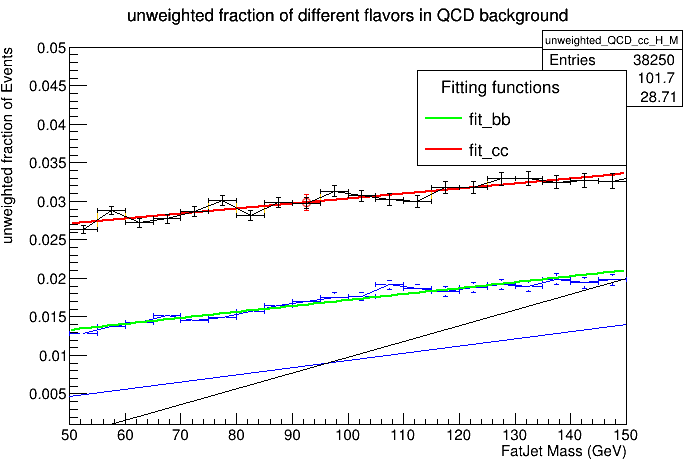

In [26]:
from array import array

fit_bb_func = TF1("fit_bb","[0]*x+[1]",50, 250)
fit_cc_func = TF1("fit_cc","[0]*x+[1]",50, 250)

fr_low=50
fr_high=150

c2 = TCanvas()
mg = TMultiGraph()
c2.Draw()
unweighted_QCD_tot.Sumw2() # Add Sumw2() everywhere to make sure it activates the error term
unweighted_QCD_bb.Sumw2()
unweighted_QCD_cc.Sumw2()
unweighted_QCD_bq.Sumw2()
unweighted_QCD_cq.Sumw2()
unweighted_QCD_qq.Sumw2()
unweighted_frac_bb = unweighted_QCD_bb.Clone()
unweighted_frac_bb.Divide(unweighted_QCD_tot)
unweighted_frac_bb.SetLineColor(kBlue)
fit_bb_func.SetLineColor(kGreen)

N = unweighted_frac_bb.GetNbinsX()
bin_x = []
bin_y_bb = []
err_x_bb = []
err_y_bb = []
for i in range(1, N):
    bin_x.append(unweighted_frac_bb.GetBinCenter(i))
    bin_y_bb.append(unweighted_frac_bb.GetBinContent(i))
    err_x_bb.append(2.5)
    err_y_bb.append(unweighted_frac_bb.GetBinError(i))
gr1=TGraphErrors(N, np.array(bin_x), np.array(bin_y_bb), np.array(err_x_bb), np.array(err_y_bb))
gr1.SetMarkerStyle(20);
gr1.SetLineColor(kBlue);
gr1.SetMarkerColor(5)

mg = TMultiGraph()

for fr_high in range(fr_high, fr_high+10, 10):
    
    print('fitting range from ', fr_low, 'to', fr_high)
    gr1.Fit('fit_bb','','', fr_low, fr_high)
    unweighted_frac_bb.Draw('histo same')
    unweighted_frac_bb.Draw('E1 same')
    
    bin_num=9
    midpoint_x = unweighted_frac_bb.GetBinCenter(bin_num)
    histo_y = unweighted_frac_bb.GetBinContent(bin_num)
    err_low = unweighted_frac_bb.GetBinErrorLow(bin_num)
    print('actual fraction = %.4f +- %.4f '%(histo_y*100, err_low*100), '%')
    a_bb = fit_bb_func.GetParameter(0)
    b_bb = fit_bb_func.GetParameter(1)
    acov_bb=fit_bb_func.GetParError(0)
    bcov_bb=fit_bb_func.GetParError(1)

    # Print the single dot with error bar
    n = 1
    x = array( 'f', [midpoint_x])
    y = array( 'f', [midpoint_x*a_bb+b_bb])
    exl_bb = array( 'f', [2.5])
    exh_bb = array( 'f', [2.5])
    eyl_bb = array( 'f', [(midpoint_x*a_bb+b_bb) - (midpoint_x*(a_bb-acov_bb)+b_bb-bcov_bb)])
    eyh_bb = array( 'f', [midpoint_x*(a_bb+acov_bb)+b_bb+bcov_bb - (midpoint_x*a_bb+b_bb)])
    gr_bb = TGraphAsymmErrors( n, x, y, exl_bb, exh_bb, eyl_bb, eyh_bb )
    gr_bb.SetLineColor(kRed)
    gr_bb.SetMarkerStyle( 21 )
    gr_bb.Draw("same")
    m_bb = TMarker(midpoint_x, midpoint_x*a_bb+b_bb, 4)
    print('fitting fraction = %.4f'%((midpoint_x*a_bb+b_bb)*100), '%', 'range is %.4f ~ %.4f'%((midpoint_x*(a_bb-acov_bb)+b_bb-bcov_bb)*100, (midpoint_x*(a_bb+acov_bb)+b_bb+bcov_bb)*100), '%')
    m_bb.SetMarkerColorAlpha(kRed,1)
    m_bb.Draw('alp same')


#print(unweighted_frac_bb.GetFunction('fit_bb').GetParameter(0))
unweighted_frac_cc = unweighted_QCD_cc.Clone()
unweighted_frac_cc.Divide(unweighted_QCD_tot)
unweighted_frac_cc.SetLineColor(kOrange)
unweighted_frac_cc.Fit('fit_cc','','', 50, 250)
unweighted_frac_cc.Draw('histo same')
unweighted_frac_cc.Draw('E1 same')

bin_y_cc = []
err_x_cc = []
err_y_cc = []
for i in range(1, N):
    bin_x.append(unweighted_frac_cc.GetBinCenter(i))
    bin_y_cc.append(unweighted_frac_cc.GetBinContent(i))
    err_x_cc.append(2.5)
    err_y_cc.append(unweighted_frac_cc.GetBinError(i))
gr2=TGraphErrors(N, np.array(bin_x), np.array(bin_y_cc), np.array(err_x_cc), np.array(err_y_cc))


print('fitting range from ', fr_low, 'to', fr_high)
unweighted_frac_cc.Fit('fit_cc','','', fr_low, fr_high)
unweighted_frac_cc.Draw('histo same')
unweighted_frac_cc.Draw('E1 same')
bin_num=9
midpoint_x = unweighted_frac_cc.GetBinCenter(bin_num)
histo_y = unweighted_frac_cc.GetBinContent(bin_num)
err_low = unweighted_frac_cc.GetBinErrorLow(bin_num)
print('actual fraction = %.4f +- %.4f '%(histo_y*100, err_low*100), '%')
a_cc = fit_cc_func.GetParameter(0)
b_cc = fit_cc_func.GetParameter(1)
acov_cc=fit_cc_func.GetParError(0)
bcov_cc=fit_cc_func.GetParError(1)

# Print the single dot with error bar
n = 1
x = array( 'f', [midpoint_x])
y = array( 'f', [midpoint_x*a_cc+b_cc])
exl_cc = array( 'f', [2.5])
exh_cc = array( 'f', [2.5])
eyl_cc = array( 'f', [(midpoint_x*a_cc+b_cc) - (midpoint_x*(a_cc-acov_cc)+b_cc-bcov_cc)])
eyh_cc = array( 'f', [midpoint_x*(a_cc+acov_cc)+b_cc+bcov_cc - (midpoint_x*a_cc+b_cc)])
gr_cc = TGraphAsymmErrors( n, x, y, exl_cc, exh_cc, eyl_cc, eyh_cc )
gr_cc.SetLineColor(kRed)
gr_cc.SetMarkerStyle( 21 )
gr_cc.Draw("same")
m_cc = TMarker(midpoint_x, midpoint_x*a_cc+b_cc, 4)
print('fitting fraction = %.4f'%((midpoint_x*a_cc+b_cc)*100), '%', 'range is %.4f ~ %.4f'%((midpoint_x*(a_cc-acov_cc)+b_cc-bcov_cc)*100, (midpoint_x*(a_cc+acov_cc)+b_cc+bcov_cc)*100), '%')
m_cc.SetMarkerColorAlpha(kRed,1)
m_cc.Draw('alp same')

legend = TLegend(0.6,0.65,.9,0.85);
legend.SetHeader("    Fitting functions ");
legend.AddEntry(fit_bb_func,"fit_bb","l");
legend.AddEntry(fit_cc_func,"fit_cc","l")
legend.Draw('same')

mg.Add(gr1)
mg.Add(gr2)
mg.Draw()

'''
unweighted_frac_bq = unweighted_QCD_bq.Clone()
unweighted_frac_bq.Divide(unweighted_QCD_tot)
unweighted_frac_bq.SetLineColor(kViolet)
unweighted_frac_bq.Draw('histo same')
unweighted_frac_bq.Draw('E1 same')
unweighted_frac_cq = unweighted_QCD_cq.Clone()
unweighted_frac_cq.Divide(unweighted_QCD_tot)
unweighted_frac_cq.SetLineColor(kRed)
unweighted_frac_cq.Draw('histo same')
unweighted_frac_cq.Draw('E1 same')
unweighted_frac_qq = unweighted_QCD_qq.Clone()
unweighted_frac_qq.Divide(unweighted_QCD_tot)
unweighted_frac_qq.SetLineColor(kGreen)
unweighted_frac_qq.Draw('histo same')
unweighted_frac_qq.Draw('E1 same')'''


unweighted_frac_cc.GetYaxis().SetRangeUser(1e-3, .05)
unweighted_frac_cc.GetXaxis().SetRangeUser(50, 150)
#c1.SetLogy()
#c2.BuildLegend()
unweighted_frac_cc.GetXaxis().SetTitle('FatJet Mass (GeV)')
unweighted_frac_cc.GetYaxis().SetTitle('unweighted fraction of Events')
unweighted_frac_cc.SetTitle("unweighted fraction of different flavors in QCD background")

bin error 1.1459799934800715e-05
bin content 0.0002842780377250165
bin upper 1.1459799934800715e-05
TH1.Print Name  = QCD_bb_H_M, Entries= 39617, Total sum= 0.00586732
TH1.Print Name  = QCD_cc_H_M, Entries= 72261, Total sum= 0.0107089
TH1.Print Name  = QCD_bq_H_M, Entries= 90223, Total sum= 0.0133978
TH1.Print Name  = QCD_cq_H_M, Entries= 232453, Total sum= 0.0350719
TH1.Print Name  = QCD_qq_H_M, Entries= 2019228, Total sum= 0.29644
TH1.Print Name  = QCD_tot_H_M, Entries= 2453782, Total sum= 0.361486


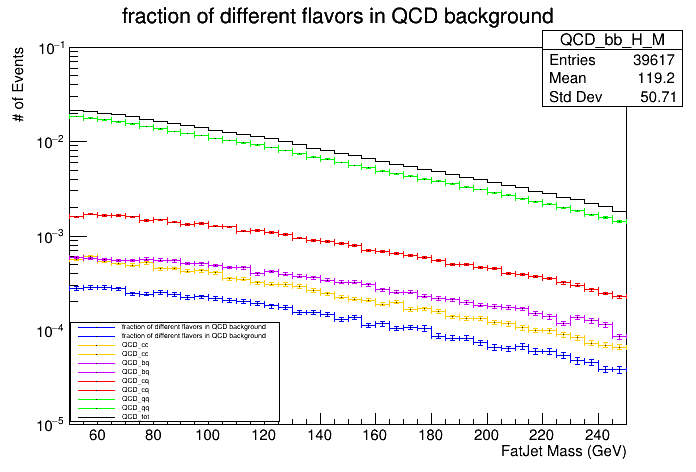

In [51]:

c = TCanvas()
c.Draw()
QCD_bb.Print()
print('bin error', QCD_bb.GetBinError(2))
print('bin content', QCD_bb.GetBinContent(2))
print('bin upper', QCD_bb.GetBinErrorLow(2))
QCD_bb.SetLineColor(kBlue)
QCD_bb.Draw('histo same')
QCD_bb.Draw('E1 same')
QCD_cc.Print()
QCD_cc.SetLineColor(kOrange)
QCD_cc.Draw('histo same')
QCD_cc.Draw('E1 same')
QCD_bq.Print()
QCD_bq.SetLineColor(kViolet)
QCD_bq.Draw('histo same')
QCD_bq.Draw('E1 same')
QCD_cq.Print()
QCD_cq.SetLineColor(kRed)
QCD_cq.Draw('histo same')
QCD_cq.Draw('E1 same')
QCD_qq.Print()
QCD_qq.SetLineColor(kGreen)
QCD_qq.Draw('histo same')
QCD_qq.Draw('E1 same')

QCD_tot.Print()
QCD_tot.SetLineColor(kBlack)
QCD_tot.Draw('histo same')

QCD_bb.GetYaxis().SetRangeUser(1e-5, .1)
c.SetLogy()
c.BuildLegend()
QCD_bb.GetXaxis().SetTitle('FatJet Mass (GeV)')
QCD_bb.GetYaxis().SetTitle('# of Events')
QCD_bb.SetTitle("weighted # of events for different flavors in QCD background")


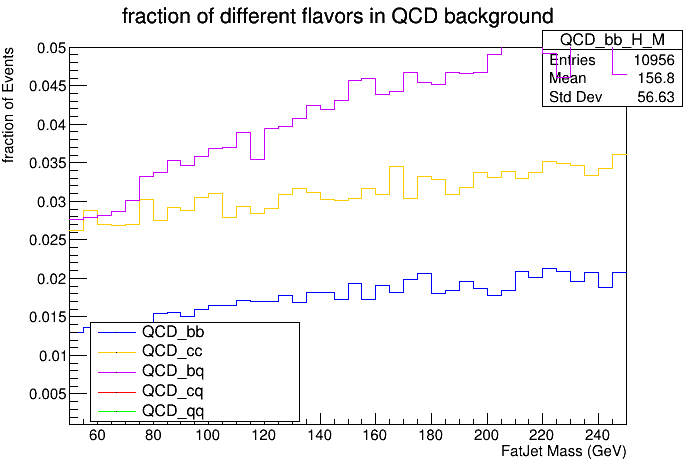

In [111]:

fit_bb_func = TF1("fit_bb","[0]*x+[1]",50, 250)
fit_cc_func = TF1("fit_cc","[0]*x+[1]",50, 250)


c1 = TCanvas()
c1.Draw()
frac_bb = QCD_bb.Clone()
frac_bb.Divide(QCD_tot)
frac_bb.SetLineColor(kBlue)
#frac_bb.Fit('fit_bb','','', 50, 250)
frac_bb.Draw('histo same')
#print(frac_bb.GetFunction('fit_bb').GetParameter(0))
frac_cc = QCD_cc.Clone()
frac_cc.Divide(QCD_tot)
frac_cc.SetLineColor(kOrange)
#frac_cc.Fit('fit_cc','','', 50, 250)
frac_cc.Draw('histo same')

frac_bq = QCD_bq.Clone()
frac_bq.Divide(QCD_tot)
frac_bq.SetLineColor(kViolet)
frac_bq.Draw('histo same')
frac_cq = QCD_cq.Clone()
frac_cq.Divide(QCD_tot)
frac_cq.SetLineColor(kRed)
frac_cq.Draw('histo same')
frac_qq = QCD_qq.Clone()
frac_qq.Divide(QCD_tot)
frac_qq.SetLineColor(kGreen)
frac_qq.Draw('histo same')


frac_bb.GetYaxis().SetRangeUser(1e-3, .05)
#c1.SetLogy()
c1.BuildLegend()
frac_bb.GetXaxis().SetTitle('FatJet Mass (GeV)')
frac_bb.GetYaxis().SetTitle('fraction of Events')
frac_bb.SetTitle("fraction of different flavors in QCD background")

In [32]:
print(frac_bb.SetError)

TypeError: void TH1::SetError(const double* error) =>
    TypeError: takes at least 1 arguments (0 given)

In [108]:
print('%f'%weight_histo_bb[10], edges[11])

0.000000 55


(0.01, 1)

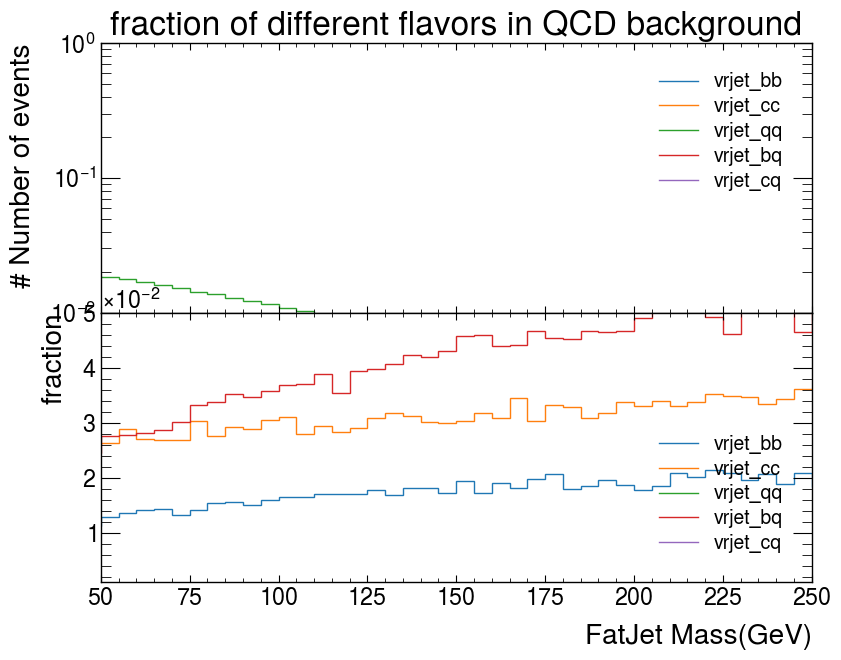

In [26]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[1, 1]}, figsize=(9,7))
fig.subplots_adjust(hspace=0)
axs[0].stairs(vrjet_histo_bb, edges, label='vrjet_bb')
axs[0].stairs(vrjet_histo_cc, edges, label='vrjet_cc')
axs[0].stairs(vrjet_histo_qq, edges, label='vrjet_qq')
axs[0].stairs(vrjet_histo_bq, edges, label='vrjet_bq')
axs[0].stairs(vrjet_histo_cq, edges, label='vrjet_cq')

vrjet_histo_tot = vrjet_histo_bb + vrjet_histo_cc + vrjet_histo_qq + vrjet_histo_bq + vrjet_histo_cq
#print(vrjet_histo_bb)
#zip = np.stack(((fatjet_bb), (fatjet_cc), (fatjet_qq), (fatjet_bq), (fatjet_cq)), axis=-1)

#axs[1].hist(zip, edges, density=True, histtype='bar', stacked=True)

axs[1].stairs(vrjet_histo_bb/vrjet_histo_tot, edges, label='vrjet_bb')
axs[1].stairs(vrjet_histo_cc/vrjet_histo_tot, edges, label='vrjet_cc')
axs[1].stairs(vrjet_histo_qq/vrjet_histo_tot, edges, label='vrjet_qq')
axs[1].stairs(vrjet_histo_bq/vrjet_histo_tot, edges, label='vrjet_bq')
axs[1].stairs(vrjet_histo_cq/vrjet_histo_tot, edges, label='vrjet_cq')
axs[1].set_xlabel('FatJet Mass(GeV)')
axs[0].set_ylabel('# Number of events')
axs[0].set_title(r'fraction of different flavors in QCD background')
axs[1].set_ylabel('fraction')
axs[1].legend()
axs[0].legend()
axs[1].set_ylim(1e-3,.05)
axs[1].set_xlim(50, 250)
#axs[1].set_yscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(1e-2, 1)
#axs[0].set_xlim(80,110)
#axs[1].set_xlim(80,110)

In [64]:
a = ak.Array([[0], [0], [0, 0], [0], [5, 0, 0], [5, 5, 0, 0], [4, 0, 0]])
#b = np.array([[0], [0], [0, 0], [0], [5, 0, 0], [4, 0, 0]])

q_filter = (a == 0)
b_filter = (a == 5)
c_filter = (a == 4)

q = ak.num(a[a==0])
b = ak.num(a[a==5])
c = ak.num(a[a==4])
print(q,b,c)
print(q[(q>1)&(b==2)])



#b = [subarray.count(5) for subarray in b]
#c = [subarray.count(4) for subarray in b]
#print(q)

[1, 1, 2, 1, 2, 2, 2] [0, 0, 0, 0, 1, 2, 0] [0, 0, 0, 0, 0, 0, 1]
[2]


In [7]:
a = ak.Array([[0], [0], [0, 0], [0], [5, 0, 0]])
good = (a==0)
print(good)

def vrjet_category(array):
    a = ak.to_numpy(array)
    vrjet_bb = np.zeros(len(a))
    vrjet_cc = np.zeros(len(a))
    vrjet_qq = np.zeros(len(a))
    vrjet_bq = np.zeros(len(a))
    vrjet_cq = np.zeros(len(a))
    
    for i in range(len(a)):
        nB = 0
        nC = 0
        nQ = 0
        for j in range(len(a[i])):
            if a[i][j] == 0:
                nQ += 1
            if a[i][j] == 5:
                nB += 1
            if a[i][j] == 4:
                nC += 1
        if nB == 2:
            vrjet_bb[i] = 1
        elif (nC == 2):
            vrjet_cc[i] = 1
        elif (nB == 1) & (nQ > 0):
            vrjet_bq[i] = 1
        elif (nC == 1) & (nQ > 0):
            vrjet_cq[i] = 1
        elif nQ > 1:
            vrjet_qq[i] = 1
    vrjet_bb = np.array(vrjet_bb, dtype=bool)
    vrjet_cc = np.array(vrjet_cc, dtype=bool)
    vrjet_qq = np.array(vrjet_qq, dtype=bool)
    vrjet_bq = np.array(vrjet_bq, dtype=bool)
    vrjet_cq = np.array(vrjet_cq, dtype=bool)
    
    return vrjet_bb, vrjet_cc, vrjet_qq, vrjet_bq, vrjet_cq
vrjet_bb, vrjet_cc, vrjet_qq, vrjet_bq, vrjet_cq = vrjet_category(a)
print(np.array(vrjet_qq, dtype=bool), vrjet_bb, vrjet_qq)

[[True], [True], [True, True], [True], [False, True, True]]
[False False  True False False] [False False False False False] [False False  True False False]


In [5]:
branch_filter = {'fatJetGN2XHbb', 'fatJetGN2XHcc', 'fatJetGN2XQCD', 'fatJetPt', 'fatJetM', 'fatJetNCHadrons', 'fatJetNBHadrons', 'vrJetIdFatJet', 'vrJetHadronGhostTruthLabelID', 'vrJetPt', 'vrJetM'}

bins = np.arange(40,500,10)
vrjet_histo_bb = np.zeros(len(bins)-1)
vrjet_histo_cc = np.zeros(len(bins)-1)
vrjet_histo_qq = np.zeros(len(bins)-1)
vrjet_histo_bq = np.zeros(len(bins)-1)
vrjet_histo_cq = np.zeros(len(bins)-1)
vrjet_histo_tot = np.zeros(len(bins)-1)
print(len(vrjet_histo_bb))

for event, report in ttree.iterate(
    library="ak",
    step_size=50000,
    filter_name=branch_filter,
    report=True,
):
    start = time.process_time()
    vrjet_mask = num_evaluate("(vrJetIdFatJet==0) & (vrJetPt>20)", event)
    vrjet_type = event['vrJetHadronGhostTruthLabelID'][vrjet_mask]
    vrjet_bb, vrjet_cc, vrjet_qq, vrjet_bq, vrjet_cq = vrjet_category(vrjet_type)
    fatjet_bb = event['fatJetM'][vrjet_bb]
    fatjet_bb = ak.sort(fatjet_bb, ascending=False)
    fatjet_bb = fatjet_bb[:, 0].to_numpy()

    fatjet_cc = event['fatJetM'][vrjet_cc]
    fatjet_cc = ak.sort(fatjet_cc, ascending=False)
    fatjet_cc = fatjet_cc[:, 0].to_numpy()

    fatjet_qq = event['fatJetM'][vrjet_qq]
    fatjet_qq = ak.sort(fatjet_qq, ascending=False)
    fatjet_qq = fatjet_qq[:, 0].to_numpy()

    fatjet_bq = event['fatJetM'][vrjet_bq]
    fatjet_bq = ak.sort(fatjet_bq, ascending=False)
    fatjet_bq = fatjet_bq[:, 0].to_numpy()

    fatjet_cq = event['fatJetM'][vrjet_cq]
    fatjet_cq = ak.sort(fatjet_cq, ascending=False)
    fatjet_cq = fatjet_cq[:, 0].to_numpy()
    
    bb, edges = np.histogram(fatjet_bb, bins=bins)
    cc, edges = np.histogram(fatjet_cc, bins=bins)
    qq, edges = np.histogram(fatjet_qq, bins=bins)
    bq, edges = np.histogram(fatjet_bq, bins=bins)
    cq, edges = np.histogram(fatjet_cq, bins=bins)
    
    vrjet_histo_bb += bb 
    vrjet_histo_cc += cc 
    vrjet_histo_qq += qq 
    vrjet_histo_bq += bq 
    vrjet_histo_cq += cq 
    print(time.process_time() - start)  
#print(vrjet_histo_bb)
    
    '''
    for i in range(len(event['fatJetM'])):
        for j in range(len(event['vrJetIdFatJet'])):
    
    vrjet_b = event['fatJetM']
    vrjet_c = event['fatJetM'][vrjet_mask_c]
    vrjet_qcd = event['fatJetM'][vrjet_mask_qcd]
    
    bb = vrjet_b[ak.num(vrjet_b) == 2]
    cc = vrjet_c[ak.num(vrjet_c) == 2]
    qq = vrjet_qcd[ak.num(vrjet_qcd) > 1]
    bqb = vrjet_b[(ak.num(vrjet_b) == 1) & (ak.num(vrjet_qcd) == 1)] # bquark in bq pair
    qbq = vrjet_qcd[(ak.num(vrjet_b) == 1) & (ak.num(vrjet_qcd) == 1)] # the other quark in bq pair
    bq = ak.concatenate([bqb,qbq])
    cqc = vrjet_c[(ak.num(vrjet_c) == 1) & (ak.num(vrjet_qcd) == 1)]
    qcq = vrjet_qcd[(ak.num(vrjet_c) == 1) & (ak.num(vrjet_qcd) == 1)]
    cq = ak.concatenate([cqc,qcq])
    tot = ak.concatenate([bb, cc, qq, bq, cq])
    
    BB = len(bb)
    CC = len(cc)
    QQ = len(qq)
    CQ = len(cq)
    BQ = len(bq)
    
    
    print('b tag', vrjet_b)
    print('c tag',vrjet_c)
    print('qcd tag',vrjet_qcd)
    
    print('bb', max(cq))
    
    print('cc', CC)
    print('qq', QQ)
    
    print('bq', bq)
    print('qb', qb)
    
    print('cq', CQ)
    print('total', BB+CC+QQ+BQ+CQ)
    
    vrjet_bb, edges = np.histogram(ak.flatten(bb).to_numpy(), bins=bins)
    vrjet_cc, edges = np.histogram(ak.flatten(cc).to_numpy(), bins=bins)
    vrjet_qq, edges = np.histogram(ak.flatten(qq).to_numpy(), bins=bins)
    vrjet_bq, edges = np.histogram(ak.flatten(bq).to_numpy(), bins=bins)
    vrjet_cq, edges = np.histogram(ak.flatten(cq).to_numpy(), bins=bins)
    vrjet_tot, edges = np.histogram(ak.flatten(tot).to_numpy(), bins=bins)

    vrjet_histo_bb += vrjet_bb
    vrjet_histo_cc += vrjet_cc
    vrjet_histo_qq += vrjet_qq
    vrjet_histo_bq += vrjet_bq
    vrjet_histo_cq += vrjet_cq
    vrjet_histo_tot += vrjet_tot
    '''

45
35.390244184
35.265591066000006
34.661387991
33.12395927
35.69127378599998
35.544062527999984
36.22150377699998
36.534143032999964
37.74807592799999
34.48571961900001
34.819026553000015
36.677335260999996
38.86944376499997
36.217934509999964
35.971728869
35.773120412000026
36.09163575499997
35.63729035799997
34.47539752700004
33.924012585000014
35.722500525999976
34.38171766300002
34.027171126999974
36.928291371
34.42591513900004
34.81537426199998
34.55320674999996
34.92568219200007
34.61331166700006
34.14109388599991
35.88892792199999
36.305212837
35.28636355000003
35.4402399789999
37.2485510250001
35.501214236999886
36.23016279299986
35.335720935000154
34.562698417999854
35.60887733000004
34.82568334000007
35.29029245299989
34.99914617399986
34.452038424999955
36.54675281100003
35.30088312199996
37.85802720800007
38.78925118699999
35.05003034099991
35.375586027000054
36.82614018200002
36.50751452700001
36.23851654000009
36.26954688400019
40.464831486000094
38.32899925600009
37.466